# Assignment 1d Notebook
This notebook builds on the EA code you've written in past assignments to guide you through implementing a multi-objective EA (MOEA). You should copy over the following files from your 1c repository:

* `base_evolution.py`
    * **EXTREMELY IMPORTANT NOTE**: The `log_multiobjective_stats` function present in previous assignments has an error you need to correct. You must rename the `front` parameter to `pareto_front`. Failing to do so will cause errors.
* `linear_genotype.py`
* `selection.py`
* `stock_population_evaluation.py`
* The `data` subdirectory

If you receive any feedback about the implementation of your algorithm in 1c, please address any problems before you conduct your experiment for 1d. You may also copy your previous notebooks over if you wish, but be careful to not overwrite the other files in the repo, as we may have made modifications to them.

Recall that you should be launching this notebook using the `EC-env` conda environment. If you are not in the `EC-env` environment, terminate the notebook server, activate the environment with `conda activate EC-env`, and restart the notebook server.

As usual, be sure to **read all of this notebook**. Start by executing the next cell.

In [1]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

!pip install snake-eyes-parser
!pip install pytest

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams['figure.figsize'] = (10.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 8.0
plt.rcParams['figure.titlesize'] = 12.0
plt.rcParams['axes.titlesize'] = 12.0
plt.rcParams['axes.labelsize'] = 8.0
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['savefig.dpi'] = 400.0

import multiprocessing

multiprocessing.set_start_method('fork', force=True)

import os
import statistics
from pathlib import Path
from snake_eyes import read_config
from cutting_stock.fitness_functions import *
from cutting_stock.visualizer import visualize
from stock_population_evaluation import *
from linear_genotype import LinearGenotype
from base_evolution import BaseEvolutionPopulation
from selection import *
from log_analyzer import *
from multiobjective import *
from stats import run_stats

print('The first cell has been executed!')

The first cell has been executed!


## Cutting Stock in Multiple Objectives
It is common for optimization problems to have multiple objectives that need to be optimized. These objectives often conflict with each other to some degree, making it difficult or impossible to find one solution that perfectly optimizes every objective. That is, there are typically *trade-offs* that need to be made between the objectives. Multi-objective optimization is a massive topic that many people have devoted their careers to studying, and not specific to any computational technique. This notebook will only cover the details relevant to a basic MOEA implementation, but a good place to start to dig into higher-level theory, if you're interested in doing so, is [the Wikipedia page on multi-objective optimization](https://en.wikipedia.org/wiki/Multi-objective_optimization).

For this assignment, we will be optimizing two objectives: minimizing the length (or x-axis distance) just as before, but now also minimizing the width (or y-axis distance). We can imagine we know what shapes we want to cut out, but our stock material is available in differing widths. We can buy stock of many possible widths, but they come at different costs. Before deciding what stock to buy, we want to see how much length of stock we would need to use for various widths. We could try running many different runs of our single-objective optimizers from assignments 1a, 1b, or 1c, but this may not be tractable and would require an excess of computational time. Instead, we will use an MOEA that can find optimized layouts for various widths all in one run!

## multiobjective_population_evaluation
We'll start with the fitness function you will be using for this assignment, `multiobjective_fitness_function`. You will use this the same as the previous fitness functions, and it's quite similar to `base_fitness_function` from assignments 1a and 1b. The only difference is it returns two fitness values instead of one, with one representing the length used by a solution (`'length'`), and the other representing the width (`'width'`). Length is exactly the same as `'fitness'` from `base_fitness_function`: length available minus length used for valid solutions, otherwise `failure_fitness` for invalid solutions. Width is calculated analogously, using width instead of length.

Execute the following cell to see an example of how to use this function and its outputs.

Output keys: ['length', 'width']
length: -1
width: -1
Solution objective scores: [-1, -1]
The solution looks like:


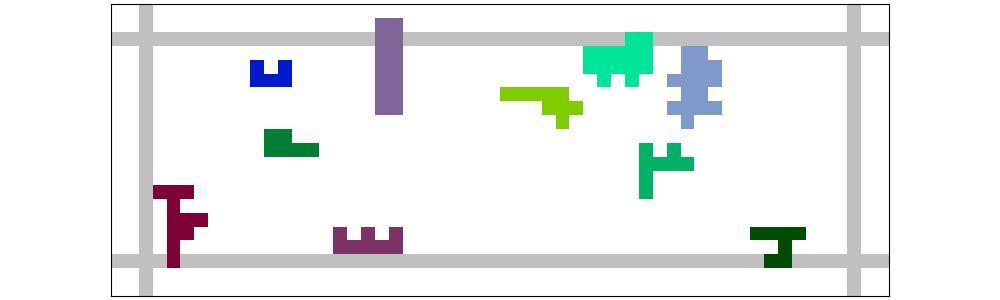

In [2]:
config = read_config('configs/1d/green_no_crowding_config.txt', globals(), locals())

test_solution = LinearGenotype()
test_solution.random_initialization(**config['problem'])

output = multiobjective_fitness_function(test_solution.genes, **config['problem'])
print('Output keys:', [key for key in output.keys()])
print('length:', output['length'])
print('width:', output['width'])

test_solution.objectives = [output['length'], output['width']]

print('Solution objective scores:', test_solution.objectives)
print('The solution looks like:')
visualize(test_solution.genes, **config['problem'])

del config, test_solution, output

Note how we assigned the fitness values into a list as the solution's `objectives` member variable, rather than assigning anything to the `fitness` member variable. It may seem weird that we're calling the fitness function and not assigning a fitness, but just trust that this will all make sense when we're done!

Now that you've seen an example of calling the new fitness function, complete the `multiobjective_population_evaluation` function in `stock_population_evaluation.py`, which populates the `objectives` member variable of all individuals in the input population, just like we did in the previous cell. It should look fairly similar to your `base_population_evaluation` function, but it will call `multiobjective_fitness_function` and assign to the `objectives` member variable rather than `fitness`. Note that length should be the first objective, and width the second objective. After you've implemented the function, run the next cell to test your implementation.

In [3]:
config = read_config('configs/1d/green_no_crowding_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(10_000, **config['problem'])

# Note explicitly initializing to None is unnecessary in general
# We only do it here to test that you've actually set these values
for individual in example_population:
    individual.objectives = None

# Calling your function to test things out
multiobjective_population_evaluation(example_population, **config['problem'])

unassigned = len([individual.objectives for individual in example_population if individual.objectives is None])

if unassigned == 0:
    lengths = [individual.objectives[0] for individual in example_population]
    print('Best length score:', max(lengths))
    print('Average length score:', statistics.mean(lengths))
    
    widths = [individual.objectives[1] for individual in example_population]
    print('Best width score:', max(widths))
    print('Average width score:', statistics.mean(widths))

else:
    print('Make sure you assign every individual objective scores, then try running this cell again.')

del config, example_population, unassigned

Best length score: 16
Average length score: -0.9816
Best width score: 3
Average width score: -0.995


## Objectives & Domination
As you can see from your implementation, in a multi-objective optimization problem, we are no longer working with a single unambiguous fitness value. In the past, we could take any two valid solutions and clearly say which one was better, or if they were equivalent, based on comparing their fitnesses. When we're considering two solutions with multiple objectives this is no longer so simple, as there are multiple scores to compare. In the code so far, we haven't even assigned a fitness! So, how do we compare different solutions?

Suppose we have two solutions, $A$ and $B$. We say that $A$ *dominates* $B$ if $A$ is strictly better than $B$ in at least one objective, and not worse than $B$ in any objectives. Then, since there is no objective where $B$ is better, but at least one objective where $A$ is better, we can say that $A$ is a strict improvement over $B$; there is no trade-off or compromise to be made between them.

To reiterate, $A$ dominates $B$ if and only if:

* $A$ is **not** worse than $B$ on *any* objective. Or, equivalently, $A$ is at least as good as $B$ on *all* objectives.
* **AND**
* $A$ is strictly better than $B$ on *any* objective.

The code to implement domination should be pretty simple, using the above bullet points. Now, implement this logic in the `dominates` function in the `multiobjective.py` file. It takes two solutions, `A` and `B`, and returns `True` if `A` dominates `B`, or `False` otherwise. We strongly recommend using the [built-in functions](https://docs.python.org/3/library/functions.html) `any` and `all` to make your algorithm as simple as possible.

The solutions will have already been evaluated by your `multiobjective_population_evaluation` function above, so they will have their `objectives` member variables set already. And remember that, although these are minimization problems, we calculate objective scores such that they should be maximized; bigger is better.

To evaluate your implementation of the `dominates` function, we're going to test your algorithm on an example population. The cell output will point out where your code produced an incorrect result.

In [4]:
example_scores = [[8,2],
                  [4,1],
                  [2,3],
                  [1,2],
                  [9,1],
                  [4,7],
                  [2,5],
                  [1,3],
                  [8,2],
                  [5,5]]

expectation =    [[2,4],
                  [],
                  [4,8],
                  [],
                  [2],
                  [2,3,4,7,8],
                  [3,4,8],
                  [4],
                  [2,4],
                  [2,3,4,7,8]]

config = read_config('configs/1d/green_no_crowding_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(len(example_scores), **config['problem'])

for index in range(len(example_population)):
    # Assigning objectives directly, rather than using
    # multiobjective_population_evaluation, for demo purposes only
    example_population[index].objectives = example_scores[index]

print('ID\tDominates')


failed = False
for index in range(len(example_population)):
    domination_list = list()

    for opponent_index in range(len(example_population)):
        if index == opponent_index:
            continue
        if dominates(example_population[index], example_population[opponent_index]):
            domination_list.append(opponent_index + 1)

    print(f'{index + 1}\t{domination_list}', end='')
    if domination_list != expectation[index]:
        print('\tExpected:', expectation[index], end='')
        failed =  True
    print('')

if failed:
    print('At least one of the calls to dominates() was incorrect. ' +\
          'The above table printed the expected output as a third column wherever there was an error.')

del expectation, config, example_population, failed, domination_list

ID	Dominates
1	[2, 4]
2	[]
3	[4, 8]
4	[]
5	[2]
6	[2, 3, 4, 7, 8]
7	[3, 4, 8]
8	[4]
9	[2, 4]
10	[2, 3, 4, 7, 8]


## Nondomination Sort & Pareto Front
In traditional MOEA implementations, such as Non-dominated Sorting Genetic Algorithm II [(NSGA-II)](https://ieeexplore.ieee.org/abstract/document/996017?casa_token=sIy9DHU74qAAAAAA:f9M0Nu6WrHIswdRILFlqhxUqW-rK1nfke65Xw88A1JNX5TaaXZAL76yrC3L8WncdUlrDi25Y7Zo), you would typically implement MOEA-specific selection operators that use the different objective scores directly in their selection process. For example, you might do `k`-tournaments by sampling `k` contestants, determining which of the `k` contestants are not dominated by any other contestants, and selecting one of these non-dominated contestants. This works because `k`-tournament selection is a rank-based algorithm, only relying on relative comparisons between individuals (more fit, less fit, or equally-fit). However, not all selection algorithms work this way - for example, fitness-proportional selection requires numeric values that are proportional to fitness.

Rather than having you write MOEA-specific selection algorithms, we will instead use a nonstandard technique (specific to this class, not drawn from EC literature or tradition) that utilizes dominance relationships to assign each individual in your population a single representative fitness value, which lets you re-use your existing selection algorithms. This technique is based on performing a *nondomination sort*, which is a well-established process in the literature. In fact, you can find a very detailed description of a nondomination sorting algorithm (along with pseudocode) in the NSGA-II paper linked above.

A nondomination sort takes the entire population, where every solution has already been evaluated, and places each one into a *level of nondomination*. This essentially represents how much a solution is dominated by other solutions. The set of solutions that are not dominated by any others is called the [*Pareto front*](https://en.wikipedia.org/wiki/Pareto_front); following from the definition of dominance, we can interpret these as the most optimal (or "best") solutions in the population. You may see references in literature using the term Pareto front to refer to the theoretically optimal set of solutions, but we use it to mean the best that you've found so far. The second level of nondomination consists of the solutions that are exclusively dominated by solutions on the Pareto front, the third level is the solutions exclusively dominated by solutions on the second level or the Pareto front, etc. Each level of nondomination consists of solutions dominated exclusively by solutions from superior levels of nondomination. If this is a bit hard to understand in text, this process was described extensively during a class lecture.

Now that we understand the terminology, our technique can be summarised in 4 steps:

1. Evaluate new individuals, assigning objective scores to each one.
2. Sort the population into levels of nondomination, where level `1` is the Pareto front, and successive levels are `1` plus the previous level (`2`, then `3`, then `4`, etc.). Assign each individual's level to its `level` member variable.
3. Calculate a fitness representing the levels of nondomination as `max_level + 1 - individual.level`, where `max_level` is the final level of nondomination. This leaves individuals on the Pareto front with fitness `max_level`, then the next level has fitness `max_level - 1`, then `max_level - 2`, etc., down to `1` for the final level. Assign this to the `fitness` member variable.
4. OPTIONAL: Subtract a crowding penalty in the range `[0, 1)` from each individual's fitness (we'll explain this later in the notebook!)

This technique, which you will soon finish implementing, yields comparisons equivalent to the NSGA-II comparison operators. Selection thus behaves similarly when using any of our rank-based selection algorithms (i.e., `k`-tournaments with or without replacement, and truncation), but additionally works with fitness-proportionate selection algorithms (i.e., FPS and SUS), though using such selection algorithms in an MOEA is practically nonexistent in literature.

You've already written the code to do step 1, `multiobjective_population_evaluation`. You've also completed the first component of step 2, `dominates`. We've provided a function for you that does step 3, so there are two functions remaining before you can assemble your MOEA.

## Assigning Levels of Nondomination
You now need to implement the `nondomination_sort` function in `multiobjective.py`, which uses the `dominates` function to sort your population into levels of nondomination and assigns each one a `level` member variable calculated as described above. This is a fairly complex operation, and you're free to implement it however you wish (including the addition of new functions to aid readability), so long as it produces the expected results. It should assign every individual a `level` member variable (step 2 above), but they should still have no `fitness` value.

As a note for optimization, this algorithm will be much quicker if you implement a domination table, or some other form of caching/memoization. That is, you can speed things up by making sure your algorithm only calls `dominates(A, B)` once for each distinct pair of `A` and `B`. Due to memory constraints and the large degree of multiprocessing, we do **not** recommend using the `functools` library's decorators to cache `dominates` calls; you should cache the results manually.

We'll evaluate your `nondomination_sort` implementation using the same example we used to evaluate `dominates`. Again, the cell will point out anywhere your code produces an incorrect result.

In [5]:
expectation = [[1,5,6,9,10],
               [2,7],
               [3],
               [8],
               [4]]

config = read_config('configs/1d/green_no_crowding_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(len(example_scores), **config['problem'])

for index in range(len(example_population)):
    # Assigning objectives directly, rather than using
    # multiobjective_population_evaluation, for demo purposes only
    example_population[index].objectives = example_scores[index]

    # Setting level to None to test your implementation
    example_population[index].level = None

# Calling your function to test things out
nondomination_sort(example_population)

if any([individual.fitness is not None for individual in example_population]):
    print('Make sure you do NOT assign fitness values, then try running this cell again.')

elif any([individual.level is None for individual in example_population]):
    print('Make sure you assign every individual a level value, then try running this cell again.')

else:
    levels = {individual.level for individual in example_population}
    levels = sorted(levels)

    expected_levels = list(range(1, len(expectation) + 1))
    if levels != expected_levels:
        print('Make sure your level values are correct.\n' +\
              f'They should be {expected_levels}, but yours were {levels}.')

    else:
        print('Level\tElements')
        for index in range(len(levels)):
            members = [i + 1 for i in range(len(example_population)) if example_population[i].level == levels[index]]
            members = sorted(members)
            print(f'{index + 1}\t{members}', end = '')
            if members != expectation[index]:
                print('\tExpected:', expectation[index], end = '')
            print('')

    del levels, expected_levels

del expectation, config, example_population

Level	Elements
1	[1, 5, 6, 9, 10]
2	[2, 7]
3	[3]
4	[8]
5	[4]


## Calculating Representative Fitness
With levels assigned, we've finished step 2 of our technique. We have provided the `assign_fitnesses` function in `multiobjective.py` for you, which will use your `nondomination_sort` implementation to assign representative fitnesses to the population. The following cell will use the same example as before to show the fitness values this function calculates.

In [6]:
expectation = [5, 4, 3, 1, 5, 5, 4, 2, 5, 5]

config = read_config('configs/1d/green_no_crowding_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(len(example_scores), **config['problem'])

for index in range(len(example_population)):
    # Assigning objectives directly, rather than using
    # multiobjective_population_evaluation, for demo purposes only
    example_population[index].objectives = example_scores[index]

    # Setting level to None to test your implementation
    example_population[index].level = None

assign_fitnesses(example_population, **config['fitness_kwargs'])

if any([individual.fitness is None for individual in example_population]):
    print('Make sure you assign every individual a fitness value, then try running this cell again.')

elif any([individual.level is None for individual in example_population]):
    print('Make sure you assign every individual a level value, then try running this cell again.')

else:
    failed = False
    print('Element\tFitness')
    for index in range(len(example_population)):
        fitness = example_population[index].fitness
        print(f'{index+1}\t{fitness}', end='')
        if fitness != expectation[index]:
            print(f'\expected{expectation[index]}')
            failed = True
        else:
            print()

    if failed:
        print('Something has gone wrong. Perhaps your nondomination sort has a bug.')

    del fitness, failed

del expectation, config, example_population

Element	Fitness
1	5
2	4
3	3
4	1
5	5
6	5
7	4
8	2
9	5
10	5


## Crowding
Now, for the very final thing to implement before you assemble the MOEA: crowding. A big problem for MOEAs is that it can become easy for many solutions to occupy a very small amount of space on the Pareto front, causing your EA to waste a lot of evaluations exploring in a very small part of the fitness landscape. That is, if we treat all individuals on each level of nondomination as equals, then, if the majority of those individuals are concentrated in one spot, we spend the majority of our time exploring around that spot. This can then lead to even more solutions in that area, making the problem worse and worse every generation. Here's a visualization that might help you understand the problem, from [a paper by Yue *et al.*](https://doi.org/10.1016/j.swevo.2021.100849):

<div>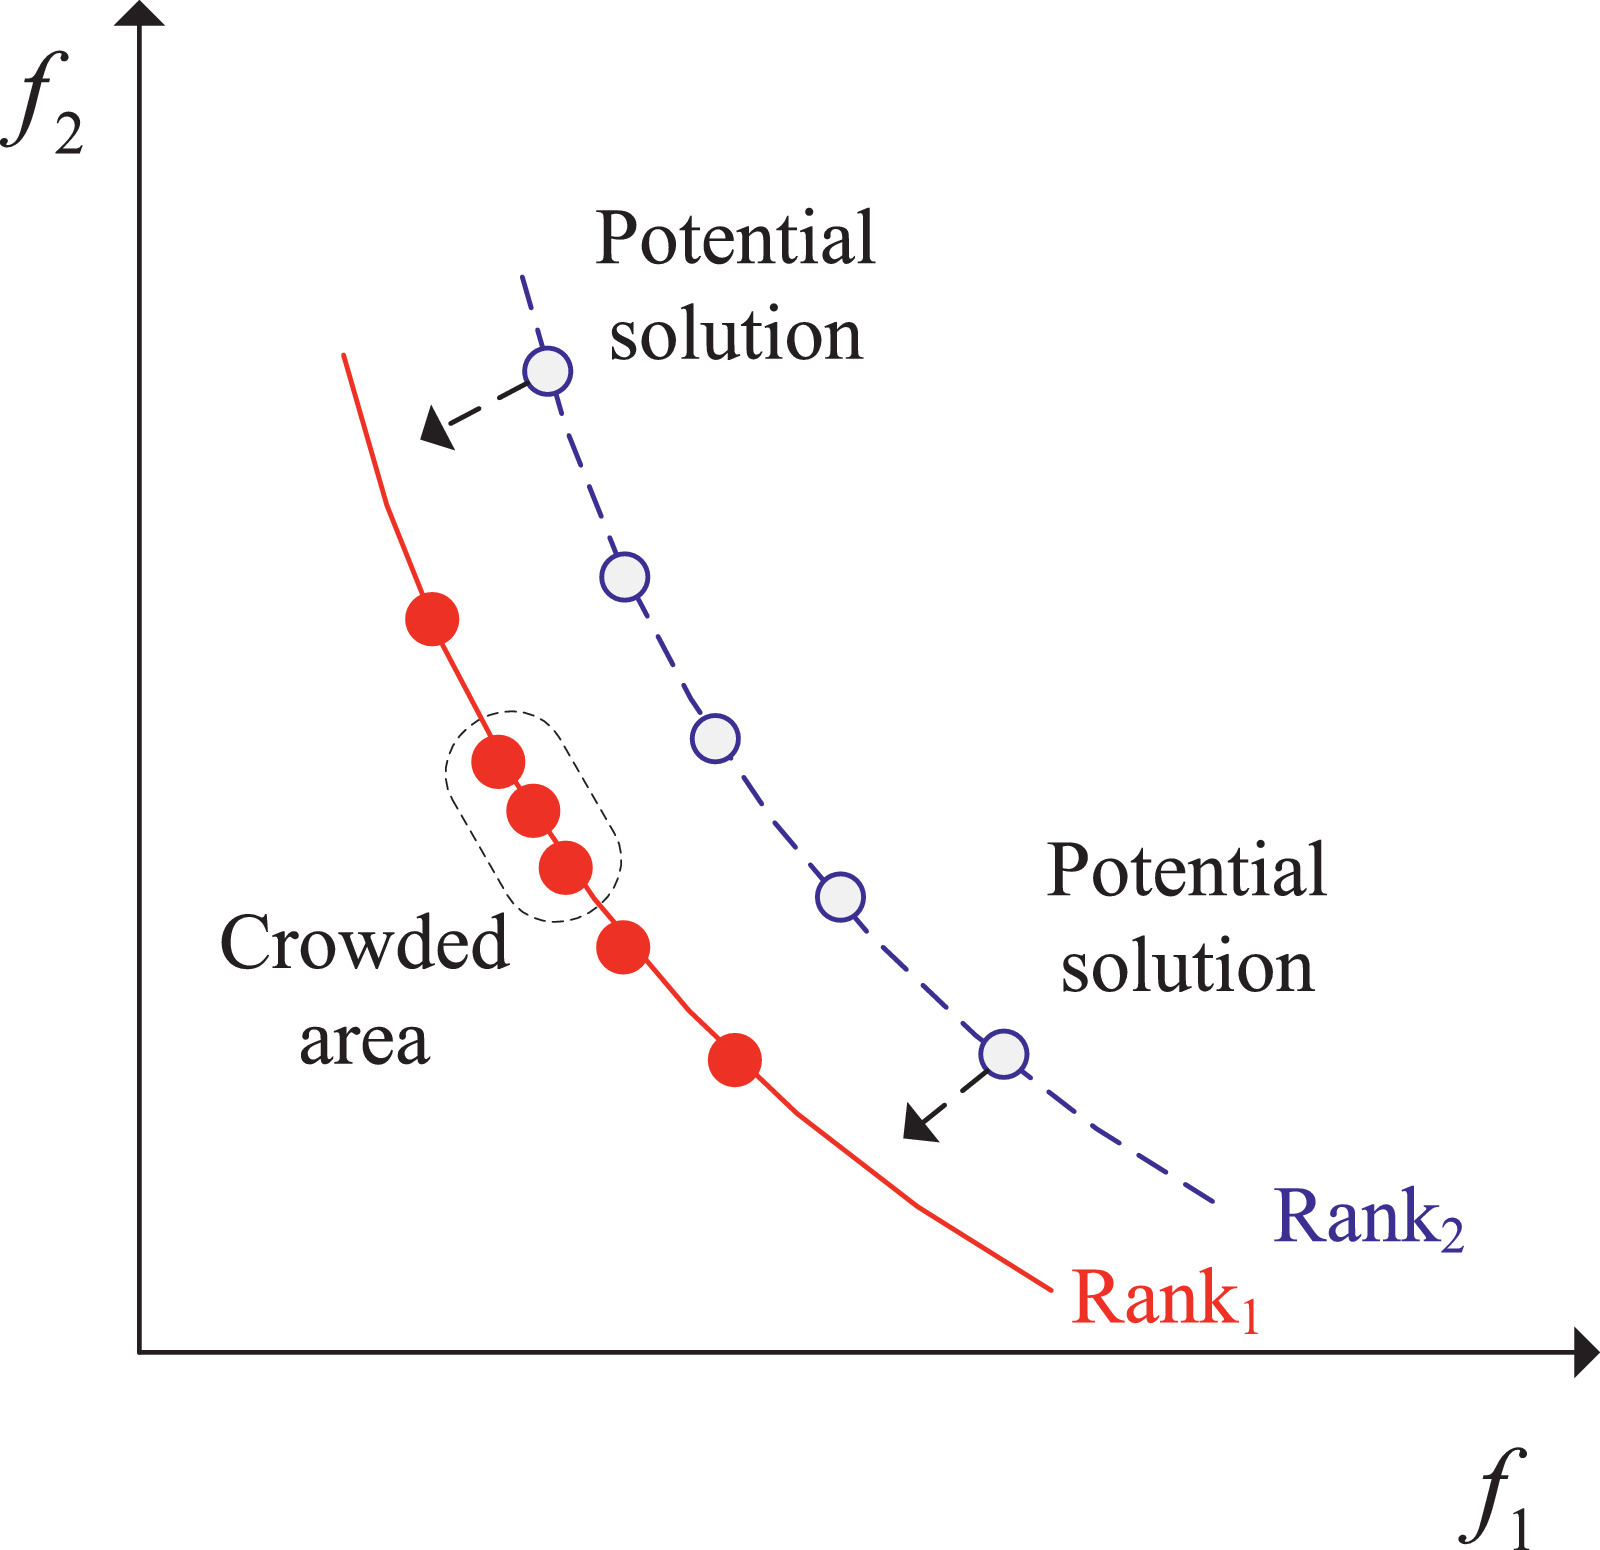</div>

Note that this visualization is formulated as trying to *minimize* objective scores, which is fairly common in the literature, but the opposite of how we are calculating objectives in this assignment series. But the overall idea still holds: while there is good reason to search around the crowded area, there may be the potential for greater improvements elsewhere. The entire point of an MOEA is to find a diverse range of solutions, so our current approach obviously has some shortcomings. MOEAs typically get around this problem by implementing *crowding*.

We require that you implement the crowding distance algorithm from the NSGA-II paper [(same link as before for convenience)](https://ieeexplore.ieee.org/abstract/document/996017?casa_token=sIy9DHU74qAAAAAA:f9M0Nu6WrHIswdRILFlqhxUqW-rK1nfke65Xw88A1JNX5TaaXZAL76yrC3L8WncdUlrDi25Y7Zo) in the `assign_crowding_distances` function of `multiobjective.py`. This function takes the entire population and assigns each individual's crowding distance to a `crowding` member variable. There are four important implementation details to highlight:

1. You should calculate crowding for each level of nondomination independently. That is, individuals are only compared against the other individuals on the same level.
2. You *must* use the `inf` constant from the `math` module to represent infinity. The first line of `multiobjective.py` imports `inf` for you already.
3. You need to account for possible division by zero. Whenever you would divide by zero, instead use `inf` as the result (i.e., replace `x/0` with `inf`).
4. There can be multiple individuals that count as being "on the boundary" of an objective, i.e., there can be multiple solutions that have the same minimal/maximal objective score. When this is the case, it is sufficient to consider the boundaries to be the first element and the last element of the sort (i.e., arbitrarily pick a minimal and a maximal solution).

Implement the `assign_crowding_distances` function before reading further. We will test it in the next code cell.

NSGA-II utilizes the crowding distance as a way to discriminate between individuals on the same level of nondomination (i.e., it is a tie-breaker). Since we've used integers as a way to represent levels of nondomination in our MOEA implementation, we can use crowding in a similar way to NSGA-II by calculating a crowding penalty for each individual in the range `[0, 1)` and subtracting this from its representative fitness. This ensures that all individuals on each level still have a greater fitness than any of the solutions on subsequent levels. That is, it serves as a way to discriminate between individuals on the same level, just as in NSGA-II.

We already implemented the code to apply this penalty for you; if your `assign_crowding_distances` function is correct, then the crowding penalty should work already. The following cell will test your implementation on the same example we've been working with previously. Note that there is an assertion in the `assign_fitnesses` function that will fail if your `assign_crowding_distances` function returns values outside of the valid range.

In [7]:
from math import inf

config = read_config('configs/1d/green_crowding_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(len(example_scores), **config['problem'])

for index in range(len(example_population)):
    # Assigning objectives directly, rather than using
    # multiobjective_population_evaluation, for demo purposes only
    example_population[index].objectives = example_scores[index]

    # Setting crowding to None to test your implementation
    example_population[index].crowding = None

assign_fitnesses(example_population, **config['fitness_kwargs'])

if any([individual.crowding is None for individual in example_population]):
    print('Make sure you assign every individual a crowding value, then try running this cell again.')

print('Crowding distances:')
print([ind.crowding for ind in example_population])

print('Fitnesses:')
print([ind.fitness for ind in example_population])

Crowding distances:
[0.7666666666666666, inf, inf, inf, inf, inf, inf, inf, 0.7, 1.6333333333333333]
Fitnesses:
[4.38295, 4, 3, 1, 5, 5, 4, 2, 4.3496500000000005, 4.81585]


The crowding distance calculation is somewhat implementation-specific (namely, how you sort solutions with the same objective score) so we can't really test your code. However, running the above cell with our implementation prints the following crowding distances:

`[0.7666666666666666, inf, inf, inf, inf, inf, inf, inf, 0.7, 1.6333333333333333]`

And the following fitnesses:

`[4.38295, 4, 3, 1, 5, 5, 4, 2, 4.3496500000000005, 4.81585]`

The first and second-to-last results in each list might be swapped in your implementation, but your results should be reasonably similar to this.

## Analyzing Multi-objective Performance
Comparing multi-objective performance is a lot more involved than the analysis you've done so far. Particularly, **our representative fitness calculated based on levels of nondomination is entirely meaningless for analysis** and generally not worth reporting at all. An individual's `fitness` only has meaning in the context of the exact population that it was sorted into, and the maximum `fitness` in a population has absolutely nothing to do with how well your MOEA has optimized the objectives. So, how do we analyze performance?

One common approach is to use a [hypervolume calculation](https://lopez-ibanez.eu/hypervolume), which essentially measures the "area under the curve" of your Pareto front's objective scores. In practice this is often an approximation, calculated by incredibly complicated algorithms that researchers devote years to perfecting. While it would be great fun to have you implement such an algorithm, we've provided a function to do it for you. Our calculation is exact (not an approximation), so you'll consistently get the same results. As an implementation detail, we calculate our hypervolumes in two objectives with a reference point of $(-1, -1)$, as the lowest possible score for a valid solution is $0$ in each objective. This is also why we have set `failure_fitness` to `-1` for this assignment, so invalid solutions contribute nothing to the hypervolume.

You can get the hypervolume using the `calculate_hypervolume` function we've provided. This function takes a Pareto front as input, and returns a number representing the Pareto front's hypervolume. The following cells show off an example of how to use this function, with the same example problem as the previous cells. Also, read the code carefully to see an example of how to get the Pareto front from a population. This will be necessary when you implement your MOEA! These cells will also visualize the Pareto front to help show you the hypervolume.

In [8]:
def plot_pareto_front(pareto_scores):
    # Matplotlib's stairs function has some unwanted behavior, so we do this manually.
    # It's a bit gross, but that's how custom matplotlib stuff often ends up...
    pareto_scores = sorted(pareto_scores, key=lambda score:score[0])
    pareto_y = []
    y_index = 0
    max_length = max(score[0] for score in pareto_scores)
    max_width = max(score[1] for score in pareto_scores)
    for x in range(max_length + 1):
        while x > pareto_scores[y_index][0]:
            y_index += 1
        pareto_y.append(pareto_scores[y_index][1])
    pareto_y.append(-2)

    with plt.ioff():
        fig, ax = plt.subplots()
        ax.set(xlabel='First objective', ylabel='Second objective',
               xlim=[-1, max_length + 1], ylim=[-1, max_width + 1])
        ax.plot(pareto_y, drawstyle='steps-pre')
        ax.axhline(pareto_y[0], -1, 1/(max_length + 2))
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        return fig, ax

The hypervolume of the Pareto front is: 57
Pareto front scores: [[4, 7], [5, 5], [8, 2], [8, 2], [9, 1]]


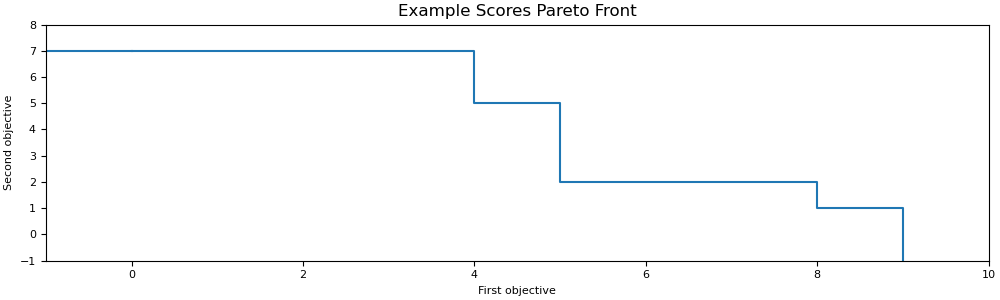

In [9]:
config = read_config('configs/1d/green_no_crowding_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(len(example_scores), **config['problem'])

for index in range(len(example_population)):
    # Assigning objectives directly, rather than using
    # multiobjective_population_evaluation, for demo purposes only
    example_population[index].objectives = example_scores[index]

# Use assign_fitnesses to assign fitnesses & levels of nondomination
assign_fitnesses(example_population, **config['fitness_kwargs'])

# Determine who is on the Pareto front
pareto_front = [individual for individual in example_population if individual.level == 1]

# Calculate the hypervolume
hypervolume = calculate_hypervolume(pareto_front)

# Print for this tutorial
print('The hypervolume of the Pareto front is:', hypervolume)

# Plot the hypervolume for this tutorial
# The code here is unimportant, just focus on the plot it produces
front_scores = [individual.objectives for individual in pareto_front]
print('Pareto front scores:', sorted(front_scores, key=lambda x:x[0]))
fig, ax = plot_pareto_front(front_scores)
ax.set_title('Example Scores Pareto Front')
fig.show()

del config, example_population, pareto_front

In [10]:
# Clean up the example we've been using
del example_scores

A greater hypervolume implies better performance. With the hypervolumes, you can conduct a t-test and interpret the results similarly as your past experiments. That is, **use the hypervolume calculated from the Pareto front from each run's final generation the same way you used the best fitness seen during a run in past assignments**. While in practice you would want to keep track of the *globally* nondominated solutions (i.e., Pareto front) during a run, similar to how you were told to use *global* best fitness in the past, we will accept simply using the *local* nondominated solutions (Pareto front) from the final generation, even with a nonelitist parameter configuration.

We also require that you log the hypervolume dominated by the local Pareto front at the end of each generation (including the initial population), in order to plot this value versus evaluation count. Since the hypervolume is the metric we are using to measure your MOEA's progress, this is similar to plotting the best fitness versus evaluations like you did in past assignments.

## Assembling the MOEA
Using the `multiobjective_population_evaluation` and `assign_fitnesses` functions, you can assemble your complete MOEA using the `BaseEvolutionPopulation` population class you implemented in Assignment 1b. There are, however, some small differences from a single-objective EA that we'll walk you through in the following examples.

In [11]:
config = read_config('configs/1d/green_crowding_config.txt', globals(), locals())

# Full initialization of your EA
example_ea = BaseEvolutionPopulation(**config['ea'], **config)

# Evaluate the initial population
multiobjective_population_evaluation(example_ea.population, **config['problem'])

# Count evaluations for initial population
example_ea.evaluations = len(example_ea.population)

# Print for tutorial purposes
print('Number of fitness evaluations:', example_ea.evaluations)

Number of fitness evaluations: 1000


Until this point, the EA looks as expected. We've read a config, initialized the EA, and evaluated the initial population. Recall, however, that the evaluation function only assigns objective scores that can't directly be used as single-value fitness in evolution. To calculate a single fitness value and evolve as usual, we have to add a call to `assign_fitnesses` **before the generational loop**. Immediately after this is where you should log data for the initial population.

Note that we've cut `mu` in the default configs down to `10_000`. Even still, this function can take several minutes to run; be patient! For optimization, it's very important to consider your data structures. If following the NSGA-II implementation, it may be more efficient to consider the use of `dict`s or `set`s for tracking dominance relationships, instead of `list`s, since the former data structures will allow for constant-time removals.

In [12]:
# Sort population and assign representative fitnesses
assign_fitnesses(example_ea.population, **config['fitness_kwargs'])

# Add values to the log after the initial generation
pareto_front = [individual for individual in example_ea.population if individual.level == 1]
hypervolume = calculate_hypervolume(pareto_front)
example_ea.log_multiobjective_stats(pareto_front, hypervolume)

Now, with fitnesses assigned to the initial population, we can begin our generational loop as usual:

In [13]:
# Generate children
children = example_ea.generate_children()

# Evaluate children
multiobjective_population_evaluation(children, **config['problem'])

# Update evaluation count
example_ea.evaluations += len(children)

# Add children to the population
example_ea.population += children

# Print for tutorial purposes
print('Number of fitness evaluations:', example_ea.evaluations)

Number of fitness evaluations: 1400


Now, with the children added, the population has changed. Recall that our representative fitness is based on levels of nondomination, and levels of nondomination depend on the entire population. Therefore, **you need to re-sort the *entire* population and re-calculate representative fitnesses** (via `assign_fitnesses`) **every time the population changes. However, inside your generational loop, you should still only evaluate the children** (via `multiobjective_population_evaluation`), **not the entire population.** You should only evaluate new individuals, but assign fitnesses to everyone! Objective scores returned by the evaluation function will always be the same for the same solution, *but its representative fitness value may change whenever the population does*.

In [14]:
# Re-sort population with children and assign representative fitness
assign_fitnesses(example_ea.population, **config['fitness_kwargs'])

With fitnesses recalculated after the children were added, we can perform survival selection as usual:

In [15]:
# Perform survival selection
example_ea.survival()

Survival selection has changed the population, so we need to re-calculate fitnesses yet again. This is also where we should log data for the current generation.

In [16]:
# Re-sort surviving population and assign representative fitness
assign_fitnesses(example_ea.population, **config['fitness_kwargs'])

# Add values to the log after the current generation
pareto_front = [individual for individual in example_ea.population if individual.level == 1]
hypervolume = calculate_hypervolume(pareto_front)
example_ea.log_multiobjective_stats(pareto_front, hypervolume)

In [17]:
# Delete variables to prevent accidental misuse
del example_ea, children, pareto_front, hypervolume

The three calls to `assign_fitnesses` (after evaluating the initial population, after adding children to the population, and after survival selection) are new additions, but otherwise the MOEA function should closely resemble the EA functions of assignments 1b and 1c. Note you also need to change the logging function to `log_multiobjective_stats`, and pass the pareto front and hypervolume as shown in the above examples.

Now that you've implemented the necessary functions and the MOEA cycle has been demonstrated, assemble your MOEA in the following cell.

Our data collection requirements are as follows:
1. (**NEW**) Return the Pareto front from the final generation as `pareto_front`
    * Note it's acceptable for this to just be calculated locally, from the final generation; you do not need to track the all-time nondominated solutions, though that would be a good idea in practice.
2. (Same as 1b/1c) Update your EA's `evaluations` member every time you evaluate individuals
   * Make sure to do this before the call to `log_multiobjective_stats()`
3. (**NEW**) Call your EA's `log_multiobjective_stats()` method after each generation (including the initial population)
    * This is the same as in 1c, just switching the method from `log_penalized_stats()`
    * Make sure to pass the pareto front and hypervolume as shown in the examples
4. (**NEW**) Return the mean and max *length scores* in the adult population at the end of each generation (including the initial population) as `mean_length_per_gen` and `max_length_per_gen`
5. (**NEW**) Return the mean and max *width scores* in the adult population at the end of each generation (including the initial population) as `mean_width_per_gen` and `max_width_per_gen`
6. (**NEW**) Return the hypervolume dominated by the Pareto front formed by the adult population at the end of each generation (including the initial population) as `hypervolume_per_gen`
7. (Same as 1b/1c) Return the cumulative evaluation count at the end of each generation (including the initial population) as `evaluation_counts`

In [18]:
def multiobjective_run(num_evaluations, config):
    # Assign the Pareto front from the final generation to this variable
    pareto_front = []

    # Assign the mean/max length at each generation to these variables
    mean_length_per_gen = []
    max_length_per_gen = []
    
    # Assign the mean/max width at each generation to these variables
    mean_width_per_gen = []
    max_width_per_gen = []

    # Assign the hypervolume dominated by the Pareto front
    # at each generation to this variable
    hypervolume_per_gen = []

    # Assign the evaluation count at each generation to this variable
    evaluation_counts = []
    
    # Initialize the EA, including an unevaluated population of size mu
    ea = BaseEvolutionPopulation(**config['ea'], **config)


    # Implement your EA here using the functionality we demonstrated in the previous cells
    # Using the above ea variable, evaluate the initial population,
    # continually run generations until you have evaluated num_evaluations solutions in total,
    # and collect data as required
    
    multiobjective_population_evaluation(ea.population, **config['problem'])

    # Update evaluation count and log statistics
    ea.evaluations = len(ea.population)
    evaluation_counts.append(ea.evaluations)

    # Assign fitnesses to the initial population
    assign_fitnesses(ea.population, **config['fitness_kwargs'])

    # Calculate and log stats for the initial population
    pareto_front = [individual for individual in ea.population if individual.level == 1]
    hypervolume = calculate_hypervolume(pareto_front)
    ea.log_multiobjective_stats(pareto_front, hypervolume)

    # Collect mean/max length and width scores for the initial population
    lengths = [ind.objectives[0] for ind in ea.population]
    widths = [ind.objectives[1] for ind in ea.population]
    mean_length_per_gen.append(statistics.mean(lengths))
    max_length_per_gen.append(max(lengths))
    mean_width_per_gen.append(statistics.mean(widths))
    max_width_per_gen.append(max(widths))
    hypervolume_per_gen.append(hypervolume)

    # Generational loop until the desired number of evaluations
    while ea.evaluations < num_evaluations:
        # Generate children
        children = ea.generate_children()

        # Evaluate only the children
        multiobjective_population_evaluation(children, **config['problem'])

        # Update evaluation count and log stats
        ea.evaluations += len(children)
        evaluation_counts.append(ea.evaluations)

        # Add children to the population
        ea.population += children

        # Re-sort population and assign fitnesses to everyone (population + children)
        assign_fitnesses(ea.population, **config['fitness_kwargs'])

        # Perform survival selection
        ea.survival()

        # Re-sort surviving population and assign fitnesses again
        assign_fitnesses(ea.population, **config['fitness_kwargs'])

        # Calculate and log stats for the current generation
        pareto_front = [individual for individual in ea.population if individual.level == 1]
        hypervolume = calculate_hypervolume(pareto_front)
        ea.log_multiobjective_stats(pareto_front, hypervolume)

        # Collect mean/max length and width scores for this generation
        lengths = [ind.objectives[0] for ind in ea.population]
        widths = [ind.objectives[1] for ind in ea.population]
        mean_length_per_gen.append(statistics.mean(lengths))
        max_length_per_gen.append(max(lengths))
        mean_width_per_gen.append(statistics.mean(widths))
        max_width_per_gen.append(max(widths))
        hypervolume_per_gen.append(hypervolume)

    # This will print outputs if it looks like anything has gone wrong.
    analyze_multiobjective_log(ea.log, num_evaluations)

    return pareto_front, mean_length_per_gen, max_length_per_gen, \
           mean_width_per_gen, max_width_per_gen, hypervolume_per_gen, \
           evaluation_counts, ea.log

Now run the next cell to test your function. **If you ever change the function in the previous cell, make sure to execute that cell again so the changes get loaded by the interpreter!** Otherwise, the changes won't take effect in other cells.

This cell may take a while. To make the example a bit quicker, we've cut `num_evaluations` down to `25_000`. If you've already changed the configs, make sure `mu` and `num_children` are low enough that you will get multiple generations with this reduced evaluation limit.

Number of solutions in the Pareto front: 6
Pareto front hypervolume: 176


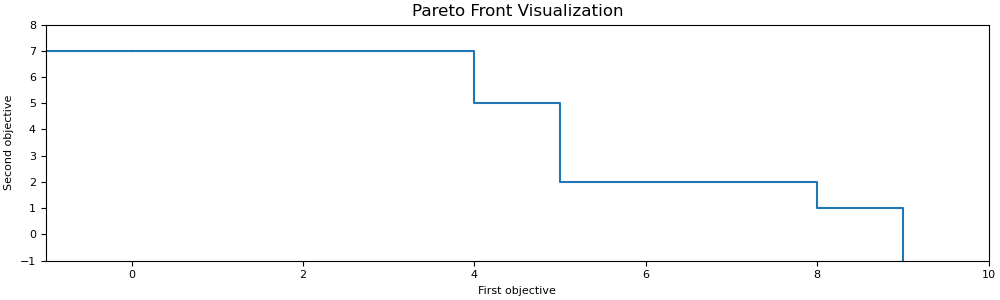

Best length score: 28
Best length looks like:


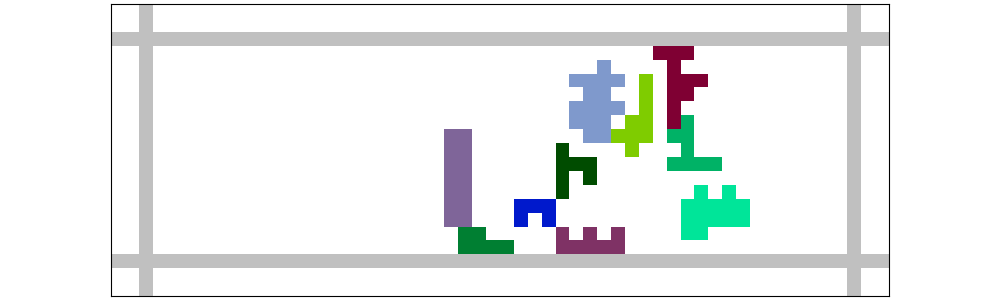

Best width score: 0
Best width looks like:


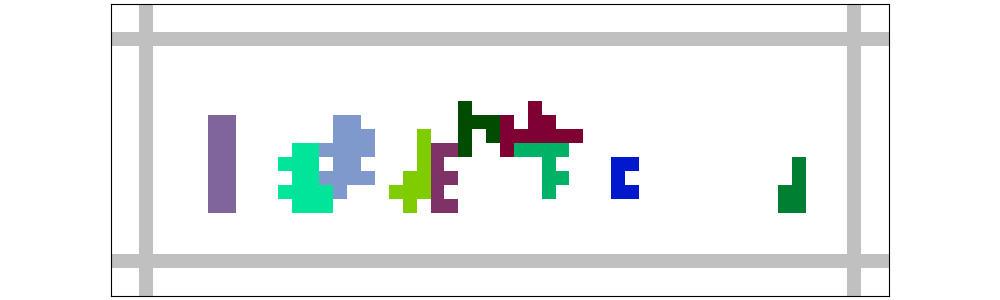

In [19]:
num_evaluations = 25_000
config = read_config('configs/1d/green_crowding_config.txt', globals(), locals())

# Testing one run of your EA (don't worry if the results are very poor, you'll improve it later on!)
(
    pareto_front,
    mean_length_per_gen,
    max_length_per_gen,
    mean_width_per_gen,
    max_width_per_gen,
    hypervolume_per_gen,
    evaluation_counts,
    log
) = multiobjective_run(num_evaluations, config)

# Save the logged values to a file for you to view
with open('example_log.txt', 'w') as f:
    f.write(''.join(line + '\n' for line in log))

print('Number of solutions in the Pareto front:', len(pareto_front))
print('Pareto front hypervolume:', calculate_hypervolume(pareto_front))
example_scores = [individual.objectives for individual in pareto_front]
fig, ax = plot_pareto_front(front_scores)
ax.set_title('Pareto Front Visualization')
fig.show()

best_length = max(pareto_front, key=lambda x:x.objectives[0])
print('Best length score:', best_length.objectives[0])
print('Best length looks like:')
visualize(best_length.genes, **config['problem'])

best_width = max(pareto_front, key=lambda x:x.objectives[1])
print('Best width score:', best_length.objectives[1])
print('Best width looks like:')
visualize(best_width.genes, **config['problem'])


del config, num_evaluations, pareto_front, mean_length_per_gen, \
    max_length_per_gen, mean_width_per_gen, max_width_per_gen, \
    hypervolume_per_gen, evaluation_counts, example_scores, fig, ax, log

If your results are dissapointingly bad, don't worry; that's expected. You'll need to tune your EA later in order to obtain decent results, and we will walk you through this process later in this notebook.

Did the log analyzer print any warnings about your algorithm at the start of the previous cell's output? If it did, this likely represents a bug in your implementation. Read the warning carefully, and try to figure out what went wrong before proceeding. Note we wrote your EA's log to `example_log.txt`, which may help in diagnosing errors.

## Experiment
Just like in previous assignments, now that you've implemented a function for a single run, it's time to implement a function for a multi-run experiment. The data you need to collect this time around is:

1. (**NEW**) The hypervolume dominated by each of the Pareto fronts from the final generation of each run (one number per run) as `hypervolume_per_run`
    * This is similar to how you were previously returning the best fitness value from each run, except it's the hypervolume of the Pareto fronts
    * This will be used for stats, the same as the fitness values were
2. (**NEW**) Of the Pareto fronts from the final generation of each run, return the one with the largest dominated hypervolume as `best_pareto_front`
    * This is similar to how you were previously returning the best solution, except you're choosing the Pareto front with the biggest hypervolume, instead of the solution with the biggest fitness
3. (**NEW**) Return the solutions which are not dominated by *any* of the solutions from the final generation of each run as `combined_pareto_front`
    * That is, calculate what the Pareto front would be if you combined the solutions from all of your runs
    * Just combine all the fronts into a single population and use the functions you've written in `multiobjective.py`; this may sound complicated but your EA loop should already have code that does something similar!
4. (**NEW**) The mean and max *length scores* in the adult population at each generation (including the initial population) in each run as `mean_length_per_gen_per_run` and `max_length_per_gen_per_run`
5. (**NEW**) The mean and max *width scores* in the adult population at each generation (including the initial population) in each run as `mean_width_per_gen_per_run` and `max_width_per_gen_per_run`
6. (**NEW**) The hypervolume dominated by the Pareto front formed by the adult population at each generation (including the initial population) in each run as `hypervolume_per_gen_per_run`
7. (Same as 1b/c) The number of evaluations at the end of each generation (including the initial population) as `evaluation_counts`

Now, implement code for a multi-run experiment in the following cell. **As a reminder, if you get pickle encoding errors, you need to re-execute the following cell.** And again, if you run into issues due to low RAM, you can manually lower the number of parallel runs by passing the `processes` parameter to `multiprocessing.Pool()`.

In [20]:
from stock_population_evaluation import multiobjective_population_evaluation
from linear_genotype import LinearGenotype
from base_evolution import BaseEvolutionPopulation
from multiobjective import *
from selection import *

# Like in past assignments, we use this function to avoid pickling errors.
# It will call your run function, serialize the best solution,
# and return the string and its non-gene members instead of the entire LinearGenotype.
def multiprocess_helper(num_evaluations, config):
    (
        pareto_front,
        mean_length_per_gen,
        max_length_per_gen,
        mean_width_per_gen,
        max_width_per_gen,
        hypervolume_per_gen,
        evaluation_counts,
        log
    ) = multiobjective_run(num_evaluations, config)
    serialized_front = []
    for solution in pareto_front:
        # Copy everything except the genes, and serialize the genes
        serialization = [solution, solution.serialize()]
        serialization[0].genes = None
        serialized_front.append(serialization)
    return serialized_front, mean_length_per_gen, max_length_per_gen, \
           mean_width_per_gen, max_width_per_gen, hypervolume_per_gen, \
           evaluation_counts, log

def calculate_combined_pareto_front(combined_population):
    combined_pareto_front = []
    for candidate in combined_population:
        dominated = False
        for member in combined_pareto_front[:]:
            if dominates(member, candidate):
                dominated = True
                break
            elif dominates(candidate, member):
                combined_pareto_front.remove(member)
        if not dominated:
            combined_pareto_front.append(candidate)
    return combined_pareto_front

def multiobjective_experiment(num_runs, num_evaluations, config):
    # We handle this for you; don't worry about the logs here
    logs = []

    # Assign the hypervolume of the Pareto front returned from each run to this variable
    # i.e., a list/tuple of num_runs numbers
    hypervolume_per_run = []

    # Assign your best Pareto front to this variable
    # It should be the Pareto front with the biggest dominated hypervolume across all runs
    best_pareto_front = None
    best_pareto_hypervolume = -float('inf')
    
    # Assign the combined Pareto front to this variable
    # It should be the solutions which are not dominated by any others across all runs
    combined_pareto_front = []

    # Use these to store the mean and max objective scores at each generation from each run
    # This should be a 2-dimensional data structure, for example:
    # mean_length_per_gen_per_run[r] is the mean_length_per_gen returned from run r
    # Therefore:
    # mean_length_per_gen_per_run[r][g] is the mean length score from run r at generation g
    mean_length_per_gen_per_run = []
    max_length_per_gen_per_run = []

    # These are similar to the above, just using width scores
    mean_width_per_gen_per_run = []
    max_width_per_gen_per_run = []

    # This is similar to the above, just using the hypervolume dominated by the Pareto front
    hypervolume_per_gen_per_run = []

    # Assign the evaluation counts at the end of each generation to this variable
    # Since this should be the same for every run in an experiment, you can just
    # return the evaluation_counts from one of the runs
    evaluation_counts = None

    # This executes your runs in parallel, using the multiprocess_helper function
    # IMPORTANT: If you are running out of RAM, as mentioned in the above text,
    # you can pass 'processes' keyword argument to multiprocessing.Pool() here
    with multiprocessing.Pool() as pool:
        args = [(num_evaluations, config)] * num_runs
        run_results = list(pool.starmap(multiprocess_helper, args))


    # Iterate over the completed runs' results
    for i in range(num_runs):
        # This gets the data from run i,
        # deserializes its Pareto front as run_pareto_front,
        # and collects the log (don't worry about the log)
        (
            serialized_front,
            mean_length_per_gen,
            max_length_per_gen,
            mean_width_per_gen,
            max_width_per_gen,
            hypervolume_per_gen,
            run_evaluation_counts,
            log
        ) = run_results[i]
        for serialized in serialized_front:
            # Deserialize the genes
            serialized[0].deserialize(serialized[1])
        run_pareto_front = [solution[0] for solution in serialized_front]
        logs.append(log)
        
        # TODO: Use run_pareto_front, mean_length_per_gen,
        #       max_length_per_gen, mean_width_per_gen,
        #       max_width_per_gen, hypervolume_per_gen, and
        #       run_evaluation_counts to collect data in the
        #       variables described at the start of this function.
    
      # Update mean and max values for length and width.
        mean_length_per_gen_per_run.append(mean_length_per_gen)
        max_length_per_gen_per_run.append(max_length_per_gen)
        mean_width_per_gen_per_run.append(mean_width_per_gen)
        max_width_per_gen_per_run.append(max_width_per_gen)

        # Update hypervolume per generation.
        hypervolume_per_gen_per_run.append(hypervolume_per_gen)

        # Storing evaluation counts for a single run.
        if evaluation_counts is None:
            evaluation_counts = run_evaluation_counts

        # Calculate the hypervolume of the Pareto front for this run.
        final_hypervolume = calculate_hypervolume(run_pareto_front)
        hypervolume_per_run.append(final_hypervolume)

        # Check if this run's Pareto front has the largest hypervolume.
        if final_hypervolume > best_pareto_hypervolume:
            best_pareto_hypervolume = final_hypervolume
            best_pareto_front = run_pareto_front

        # Add current Pareto front to the combined population.
        combined_pareto_front.extend(run_pareto_front)

    # Compute the combined Pareto front.
    combined_pareto_front = calculate_combined_pareto_front(combined_pareto_front)


    

    return hypervolume_per_run, best_pareto_front, combined_pareto_front, \
           mean_length_per_gen_per_run, max_length_per_gen_per_run, \
           mean_width_per_gen_per_run, max_width_per_gen_per_run, \
           hypervolume_per_gen_per_run, evaluation_counts, logs

Let's run a quick test in the next cell to make sure everything works, before we embark on a full experiment. As a reminder, **if you change the previous cell, make sure to re-run that cell to save the changes to your function!** We'll do 3 runs. As with the previous example, we've lowered the evaluation limit to `25_000`.

In [21]:
example_num_runs = 3
example_num_evaluations = 25_000
config = read_config('configs/1d/green_crowding_config.txt', globals(), locals())

(
    example_hypervolume_per_run,
    example_best_pareto_front,
    example_combined_pareto_front,
    example_mean_length_per_gen_per_run,
    example_max_length_per_gen_per_run,
    example_mean_width_per_gen_per_run,
    example_max_width_per_gen_per_run,
    example_hypervolume_per_gen_per_run,
    example_evaluation_counts,
    example_logs
) = multiobjective_experiment(example_num_runs,
                              example_num_evaluations,
                              config)

print('Correct number of hypervolumes?', example_num_runs == len(example_hypervolume_per_run))
print('Correct number of runs in mean length per gen data?', example_num_runs == len(example_mean_length_per_gen_per_run))
print('Correct number of runs in best length per gen data?', example_num_runs == len(example_max_length_per_gen_per_run))
print('Correct number of runs in mean width per gen data?', example_num_runs == len(example_mean_width_per_gen_per_run))
print('Correct number of runs in best width per gen data?', example_num_runs == len(example_max_width_per_gen_per_run))
print('Correct number of runs in hypervolume per gen data?', example_num_runs == len(example_hypervolume_per_gen_per_run))

print('Hypervolume per run:', example_hypervolume_per_run)

Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Correct number of hypervolumes? True
Correct number of runs in mean length per gen data? True
Correct number of runs in best length per gen data? True
Correct number of runs in mean width per gen data? True
Correct number of runs in best width per gen data? True
Correct number of runs in hypervolume per gen data? True
Hypervolume per run: [186, 151, 165]


Just like in previous assignments, we've provided a function to save your experimental data for you:

In [22]:
def save_data(hypervolume_per_run, best_pareto_front, combined_pareto_front, \
              mean_length_per_gen_per_run, max_length_per_gen_per_run, \
              mean_width_per_gen_per_run, max_width_per_gen_per_run, \
              hypervolume_per_gen_per_run, evaluation_counts, logs, subdir, config):
    subdir.mkdir(parents=True, exist_ok=True)

    def write_front(dir_name, front):
        frontdir = subdir / dir_name
        frontdir.mkdir(exist_ok=True)
        for file in frontdir.iterdir(): 
            file.unlink()
        for i, solution in enumerate(front):
            with open(frontdir/f'solution_{i}.txt', 'w') as f:
                f.write(solution.serialize())

        # We will visualize a subset of the solutions
        if len(front) <= 5:
            for i, solution in enumerate(front):
                visualize(solution.genes, path=frontdir/f'{i}.png', **config['problem'])
        else:
            best_length = max(front, key=lambda x:x.objectives[0])
            best_width = max(front, key=lambda x:x.objectives[1])
            others = set(front) - {best_length, best_width}
            random_others = random.sample(list(others), k=3)
            visualize(best_length.genes, path=frontdir/'best_length.png', **config['problem'])
            visualize(best_width.genes, path=frontdir/'best_width.png', **config['problem'])
            for i, other in enumerate(random_others):
                visualize(other.genes, path=frontdir/f'random_{i}.png', **config['problem'])
            

    write_front('best_front', best_pareto_front)
    write_front('combined_front', combined_pareto_front)
        
    with open(subdir / 'hypervolume_per_run.txt', 'w') as f:
        for result in hypervolume_per_run:
            f.write(str(result) + '\n')

    with open(subdir / 'mean_length_per_gen_per_run.txt', 'w') as f:
        f.write(str(mean_length_per_gen_per_run))

    with open(subdir / 'max_length_per_gen_per_run.txt', 'w') as f:
        f.write(str(max_length_per_gen_per_run))

    with open(subdir / 'mean_width_per_gen_per_run.txt', 'w') as f:
        f.write(str(mean_width_per_gen_per_run))

    with open(subdir / 'max_width_per_gen_per_run.txt', 'w') as f:
        f.write(str(max_width_per_gen_per_run))

    with open(subdir / 'hypervolume_per_gen_per_run.txt', 'w') as f:
        f.write(str(hypervolume_per_gen_per_run))

    with open(subdir / 'evaluation_counts.txt', 'w') as f:
        f.write(str(evaluation_counts))

    logdir = subdir / 'logs'
    logdir.mkdir(exist_ok=True)
    for i in range(len(logs)):
        with (logdir / f'{i}.txt').open('w') as f:
            f.write(''.join(line + '\n' for line in logs[i]))

    print('Data saved to', subdir)

Run the following cell and navigate to `data/1d/example/` to inspect the results and make sure everything looks correct.

In [23]:
save_data(example_hypervolume_per_run,
          example_best_pareto_front,
          example_combined_pareto_front,
          example_mean_length_per_gen_per_run,
          example_max_length_per_gen_per_run,
          example_mean_width_per_gen_per_run,
          example_max_width_per_gen_per_run,
          example_hypervolume_per_gen_per_run,
          example_evaluation_counts,
          example_logs,
          Path('./data/1d/example/'),
          config)

Data saved to data/1d/example


### Evals-vs-metrics Plot
We ask you to generate an evals-vs-metrics plot similar to the ones you generated in assignments 1b and 1c, except this time you should plot the mean and max of both objective scores and the hypervolume dominated by the Pareto front at each generation, averaged across all runs. Here's an example of such a plot:

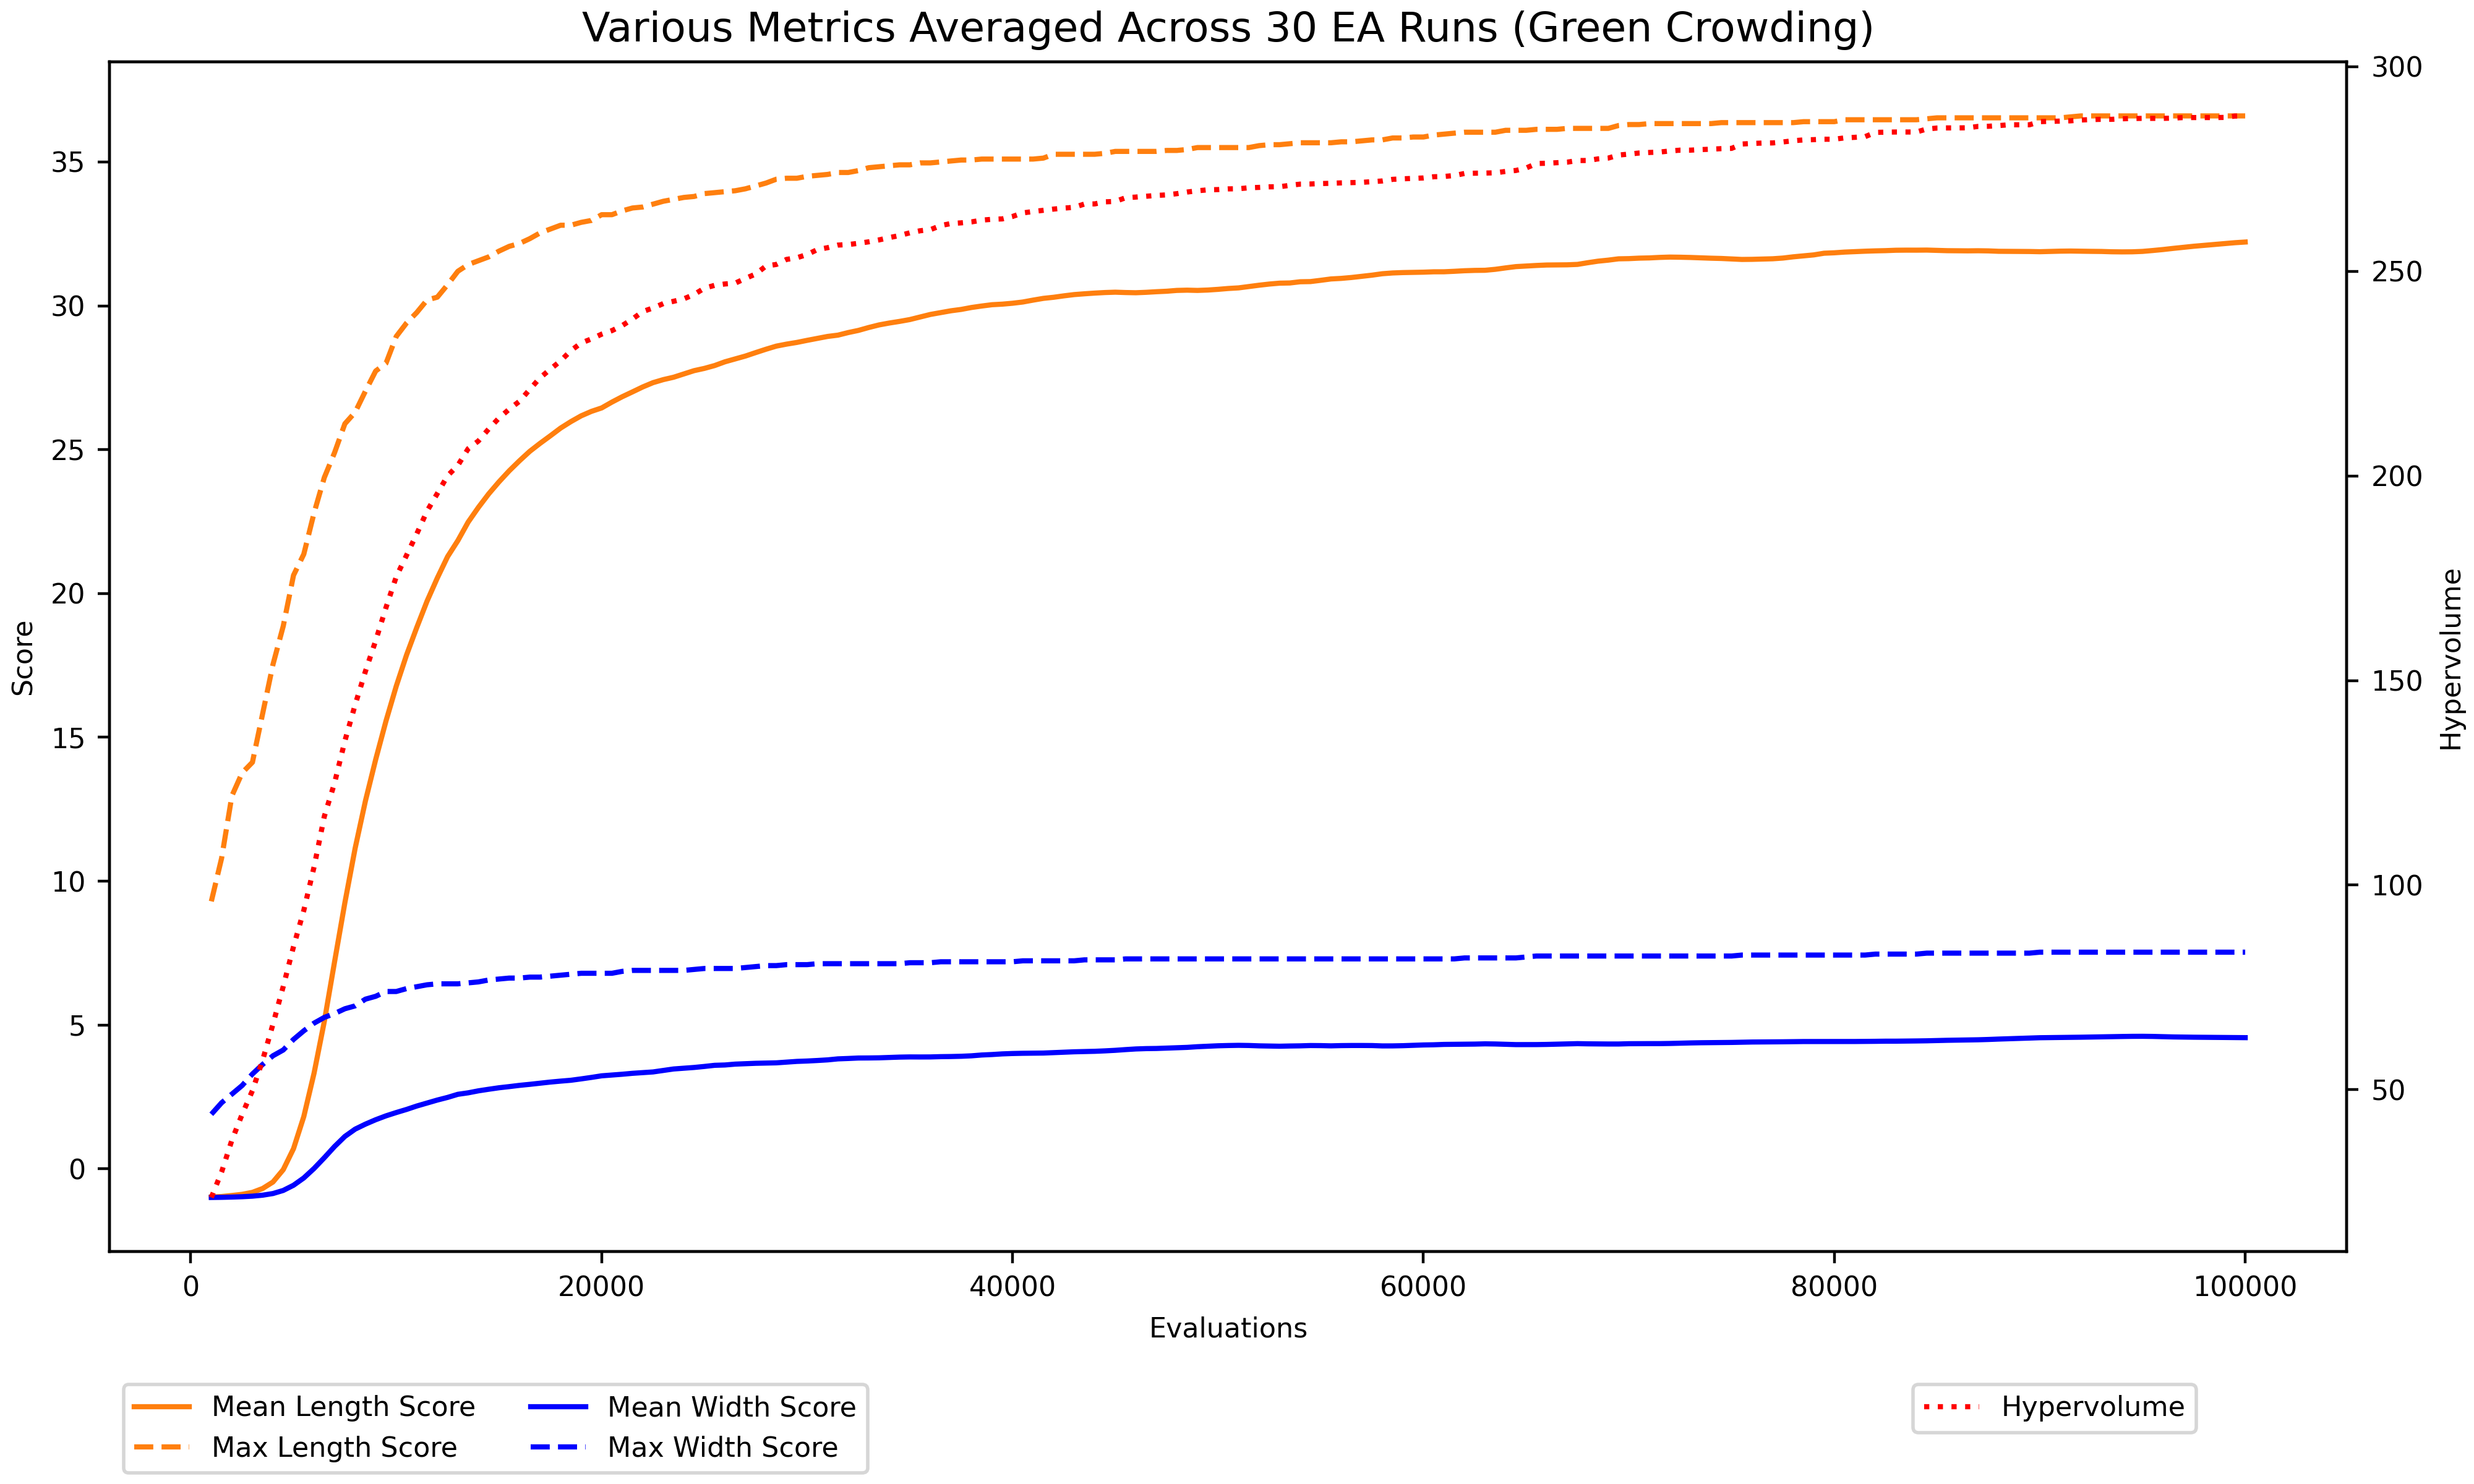

In the following cell, finish implementing the function to generate this plot:

In [27]:

def evals_vs_fitness(mean_length_per_gen_per_run, max_length_per_gen_per_run, \
                     mean_width_per_gen_per_run, max_width_per_gen_per_run, \
                     hypervolume_per_gen_per_run, evaluation_counts, title, filename):
    # Using the input mean_length_per_gen_per_run and max_length_per_gen_per_run values,
    # store the y-values for mean length score in average_length_means,
    # and the y-values for max length score in average_length_maxes.
    average_length_means = np.mean(mean_length_per_gen_per_run, axis=0)
    average_length_maxes = np.mean(max_length_per_gen_per_run, axis=0)

    # This is similar to the above, but with the values for width scores.
    average_width_means = np.mean(mean_width_per_gen_per_run, axis=0)
    average_width_maxes = np.mean(max_width_per_gen_per_run, axis=0)

    # This is similar to the above, but with the values for hypervolumes.
    average_hypervolume = np.mean(hypervolume_per_gen_per_run, axis=0)



    
    # This will make the plot for you
    with plt.ioff():
        fig, ax = plt.subplots(figsize=(10.0, 6.0))
        ax.set(xlabel='Evaluations', title=title)
        ax2 = ax.twinx()
        ax.plot(evaluation_counts, average_length_means, '-', color='tab:orange')
        ax.plot(evaluation_counts, average_length_maxes, '--', color='tab:orange')
        ax.plot(evaluation_counts, average_width_means, 'b-')
        ax.plot(evaluation_counts, average_width_maxes, 'b--')
        ax.legend(['Mean Length Score', 'Max Length Score', \
                   'Mean Width Score', 'Max Width Score'], \
                  loc='upper left', bbox_to_anchor=(0, -0.1), ncols=2)
        ax.set(ylabel='Score')
        ax2.plot(evaluation_counts, average_hypervolume, 'r:')
        ax2.set(ylabel='Hypervolume')
        ax2.legend(['Hypervolume'], \
                   loc='upper left', bbox_to_anchor=(0.8, -0.1))
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = True
        fig.savefig(filename)
        fig.show()

With that function completed, run the following cell to generate your evals-vs-fitness plot. We'll save it to `data/1d/example/plot.png`, as well as display it. If you haven't modified the config, this plot may look a little strange; if the lines are mostly horizontal, that is completely fine. Still, you should double-check that the plot agrees with the data that you collected.

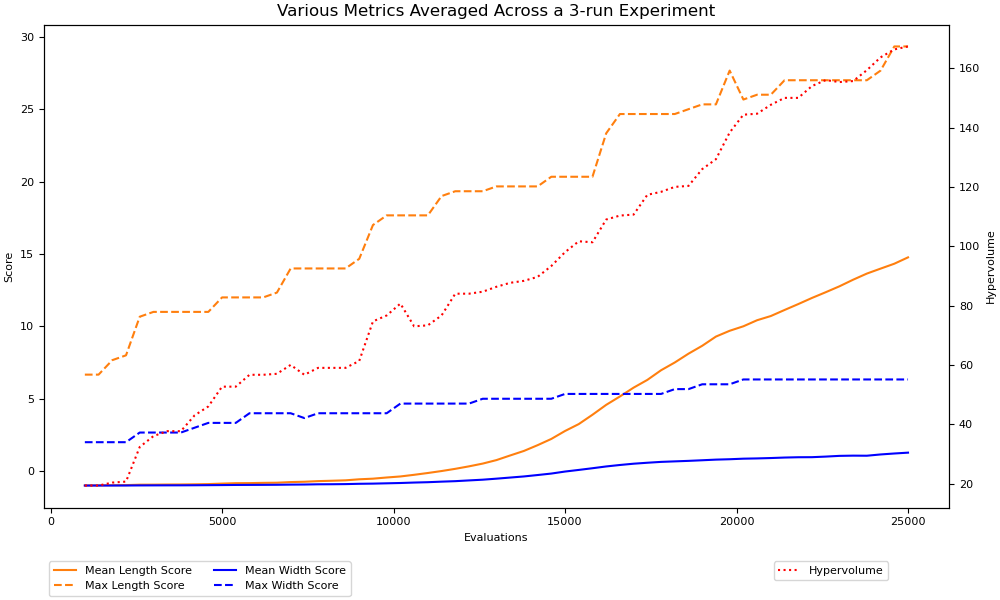

In [41]:
evals_vs_fitness(example_mean_length_per_gen_per_run,
                 example_max_length_per_gen_per_run,
                 example_mean_width_per_gen_per_run,
                 example_max_width_per_gen_per_run,
                 example_hypervolume_per_gen_per_run,
                 example_evaluation_counts,
                 'Various Metrics Averaged Across a 3-run Experiment',
                 'data/1d/example/plot.png')

Since you will be running many different experiments, we will define one more function to reduce boilerplate. This function encapsulates both running an experiment and saving all the necessary data.

In [29]:
def experiment_and_save(num_runs, num_evaluations, config, data_dir, problem_name):
    (
        hypervolume_per_run,
        best_pareto_front,
        combined_pareto_front,
        mean_length_per_gen_per_run,
        max_length_per_gen_per_run,
        mean_width_per_gen_per_run,
        max_width_per_gen_per_run,
        hypervolume_per_gen_per_run,
        evaluation_counts,
        logs
    ) = multiobjective_experiment(num_runs,
                                  num_evaluations,
                                  config)

    save_data(hypervolume_per_run,
              best_pareto_front,
              combined_pareto_front,
              mean_length_per_gen_per_run,
              max_length_per_gen_per_run,
              mean_width_per_gen_per_run,
              max_width_per_gen_per_run,
              hypervolume_per_gen_per_run,
              evaluation_counts,
              logs,
              data_dir,
              config)

    evals_vs_fitness(mean_length_per_gen_per_run,
                     max_length_per_gen_per_run,
                     mean_width_per_gen_per_run,
                     max_width_per_gen_per_run,
                     hypervolume_per_gen_per_run,
                     evaluation_counts,
                     f'Various Metrics Averaged Across {num_runs} EA Runs ({problem_name})',
                     data_dir / 'plot.png')

    front_scores = [individual.objectives for individual in best_pareto_front]
    fig, ax = plot_pareto_front(front_scores)
    ax.set_title(f'Best Pareto Front Hypervolume ({problem_name})')
    fig.savefig(data_dir / 'best_front.png')
    fig.show()
    
    combined_scores = [individual.objectives for individual in combined_pareto_front]
    fig, ax = plot_pareto_front(combined_scores)
    ax.set_title(f'Combined Pareto Front Hypervolume ({problem_name})')
    fig.savefig(data_dir / 'combined_front.png')
    fig.show()

## Tuning
You will be running two experiments: one with crowding, and one without crowding. We have no specific requirements for tuning your MOEAs, though we will still penalize for extremely poor parameters. We strongly encourage you to use the following cells to explore the parameter space at least a little bit. You may want to use your 1b configuration as a starting point. However, because the nondomination sort is $O(n^2)$, and must be called many times, the amount of time taken by a run is highly sensitive to your population sizes (`mu` and `num_children`). However, **we require that you set `mu` to be *at least* `1_000`.**

Before tuning, as usual, we have a few questions for you to answer.

**Question 1** (1%): Why would an EA with $\mu=1$ be unable to produce an optimal hypervolume on this problem instance?

Answer Question 1 here (double-click to edit) because having a population size of u = 1 wouldn't allow the algorithm to explore enough different solutions.so the algorithm won't find a good variety of tradeoffs between objectives, it won't cover the Pareto front well, and it won't get the best hypervolume, unlike bigger population ( can help us find better solution) 

**Question 2** (2%): Suppose you observe the mean width objective score decreasing over the course of your runs (i.e., you see the line has a negative slope on your plot). Is this a sign of a problem with your algorithm and/or config? Why or why not?

Answer Question 2 here (double-click to edit) it could mean there is a problem, when the algorithm focuses too much on certain solutions and doesn't explore enough different ones that can that can lead the algorithm to getting stuck in bad area or the configs are not helping it to find better solutinons. it can also mean that the algorithm isn’t keeping enough variety in the population, so it’s getting stuck and missing better options.

**Question 3** (2%): Describe in your own words why the hypervolume of the Pareto front is a reasonable measure of multiobjective performance.

Answer Question 3 here (double-click to edit) The hypervolume of the Pareto front is a good way to measure how well the solutions balance different goals because It shows how much of the solution space is covered by these solution, and  a bigger hypervolume means the solutions do a better job of balancing the different goals. It’s a good measure because it looks at all the solutions together, not just one at a time.

In [30]:
def tuning_experiment(num_runs, num_evaluations, config_path, problem_name):
    config = read_config(config_path, globals(), locals())
    config_text = config_path.read_text()

    # Set up a new subdirectory for us to save artifacts to
    base_subdir = Path('./tuning/') / config_path.parent.name / config_path.stem
    base_subdir.mkdir(parents=True, exist_ok=True)
    children = set(int(child.stem) for child in base_subdir.iterdir())
    if children:
        index = max(children) + 1
    else:
        index = 1
    subdir = base_subdir / str(index)

    # Run your EA experiment and save the data
    experiment_and_save(num_runs, num_evaluations, config, subdir, problem_name)

    # Make a copy of the config
    config_copy = subdir / config_path.name
    config_copy.write_text(config_path.read_text())

    # Print average hypervolume
    with open(subdir / 'hypervolume_per_run.txt', 'r') as f:
        hypervolume_per_run = [int(line) for line in f.readlines()]
    print('Average hypervolume:', statistics.mean(hypervolume_per_run))

In [75]:
# for tunning i used num_eval(lambda) = 100, it took 5 hours to run each cell here so i had to change it while doing 30 runs in the EA :/

Data saved to tuning/1d/green_crowding_config/1


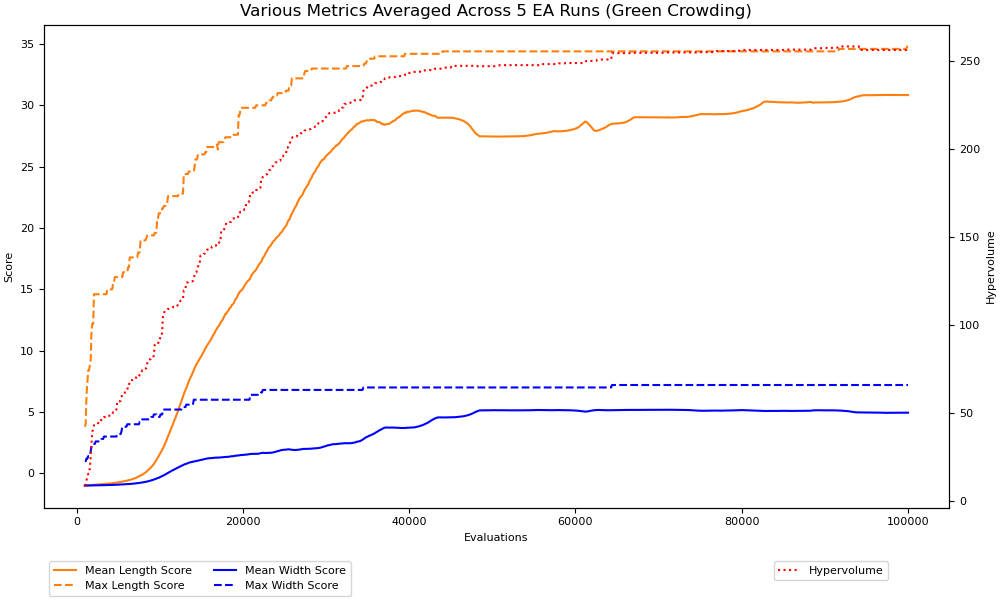

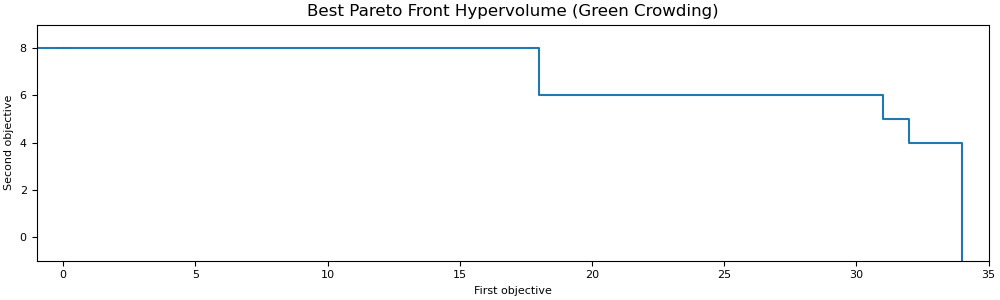

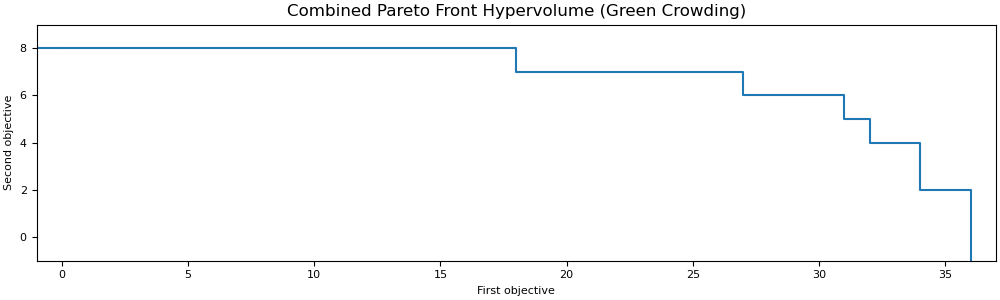

Average hypervolume: 256.6


In [49]:
tuning_runs = 5 # Note you can increase this with no time loss if you have more CPU cores
num_evaluations = 100_000
green_crowding_config_path = Path('./configs/1d/green_crowding_config.txt')

tuning_experiment(tuning_runs, num_evaluations, green_crowding_config_path, 'Green Crowding')

Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Data saved to tuning/1d/green_no_crowding_config/2


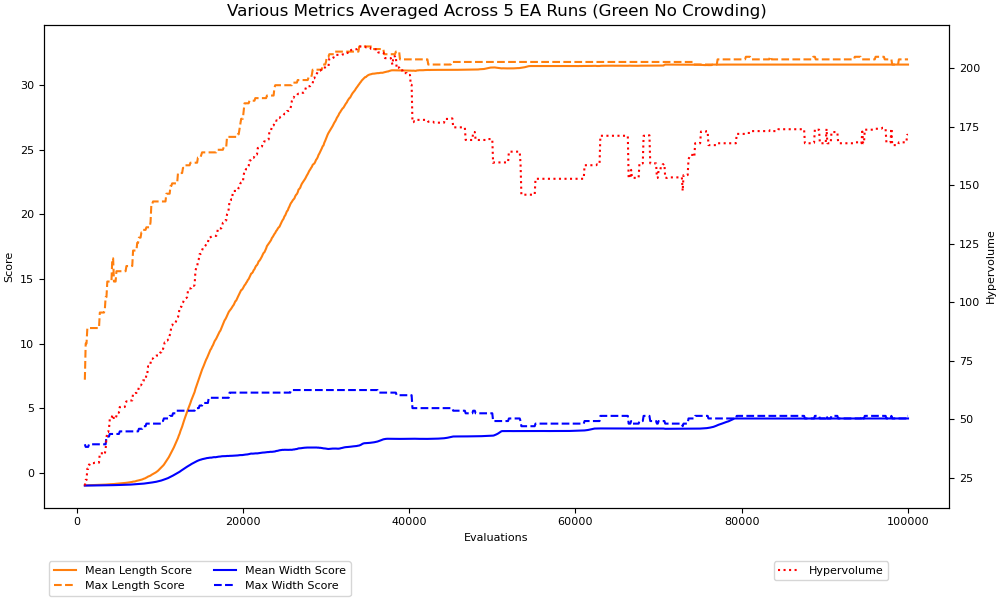

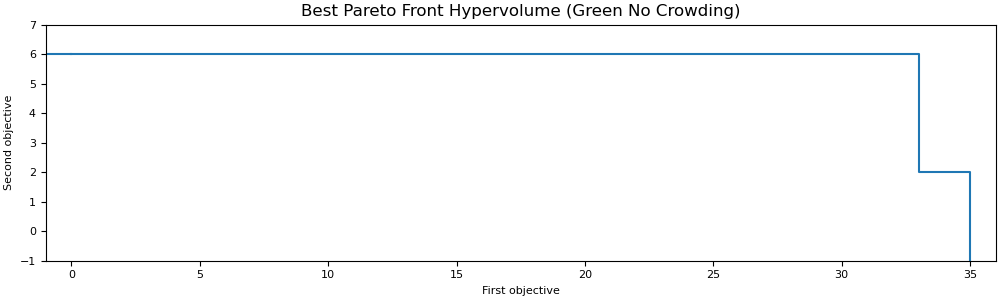

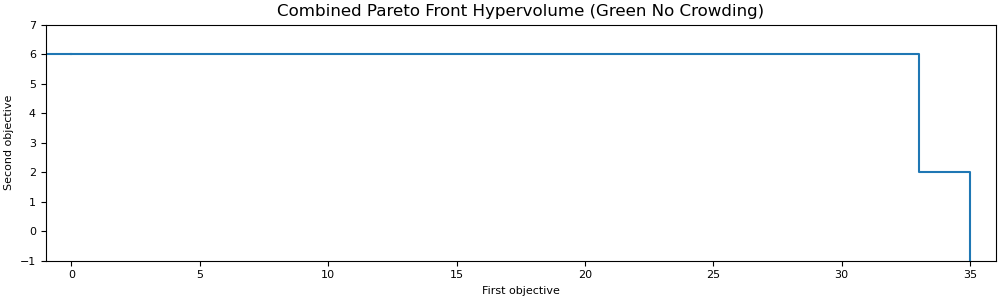

Average hypervolume: 171.6


In [51]:
tuning_runs = 5 # Note you can increase this with no time loss if you have more CPU cores
num_evaluations = 100_000
green_no_crowding_config_path = Path('./configs/1d/green_no_crowding_config.txt')

tuning_experiment(tuning_runs, num_evaluations, green_no_crowding_config_path, 'Green No Crowding')

## Running Your EA
With your tuning complete, you can execute the following cell to run your full experiments!

In [ ]:
#  I used num_evalution 400 because when i used 100 it was running for straight 16 hours so i had to faster my running time somehow /: 

Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you delib

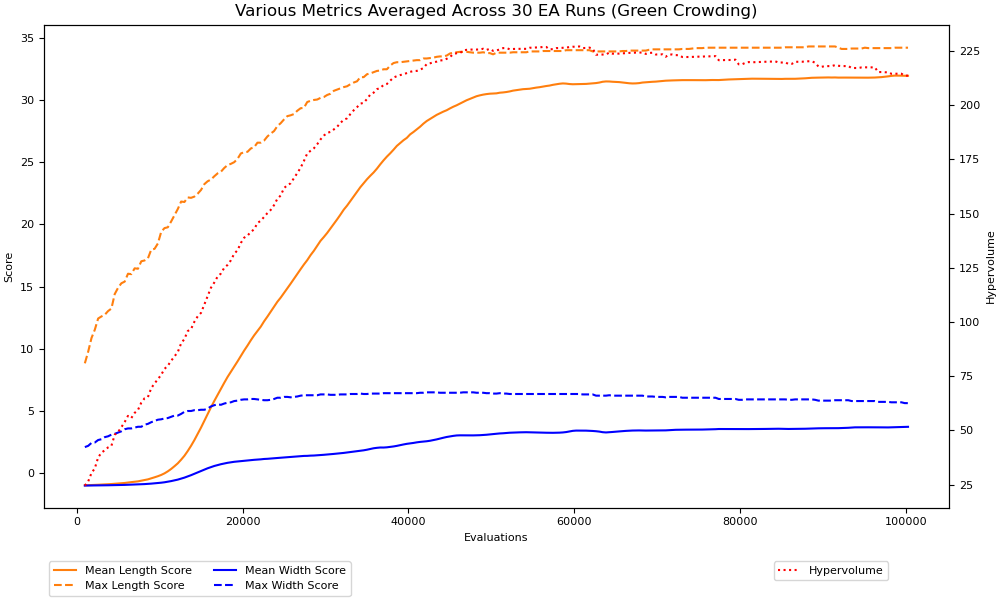

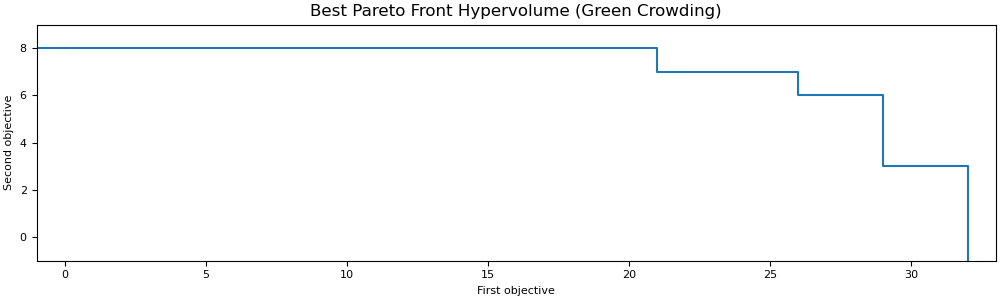

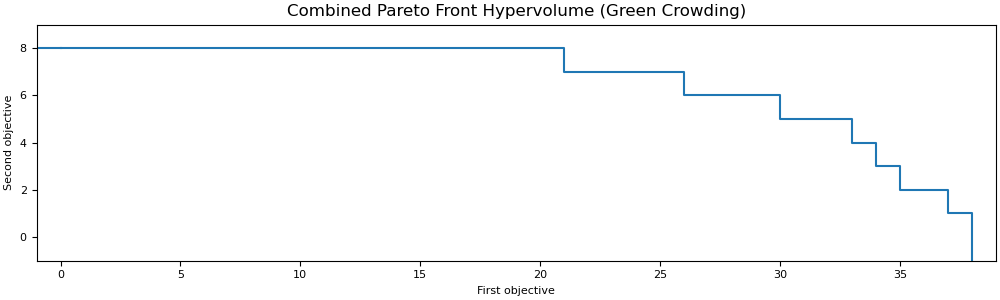

In [90]:
num_runs = 30
num_evaluations = 100_000
green_crowding_config = read_config('configs/1d/green_crowding_config.txt', globals(), locals())
green_crowding_data_path = Path('./data/1d/green_crowding/')

experiment_and_save(num_runs,
                    num_evaluations,
                    green_crowding_config,
                    green_crowding_data_path,
                    'Green Crowding')

Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you delib

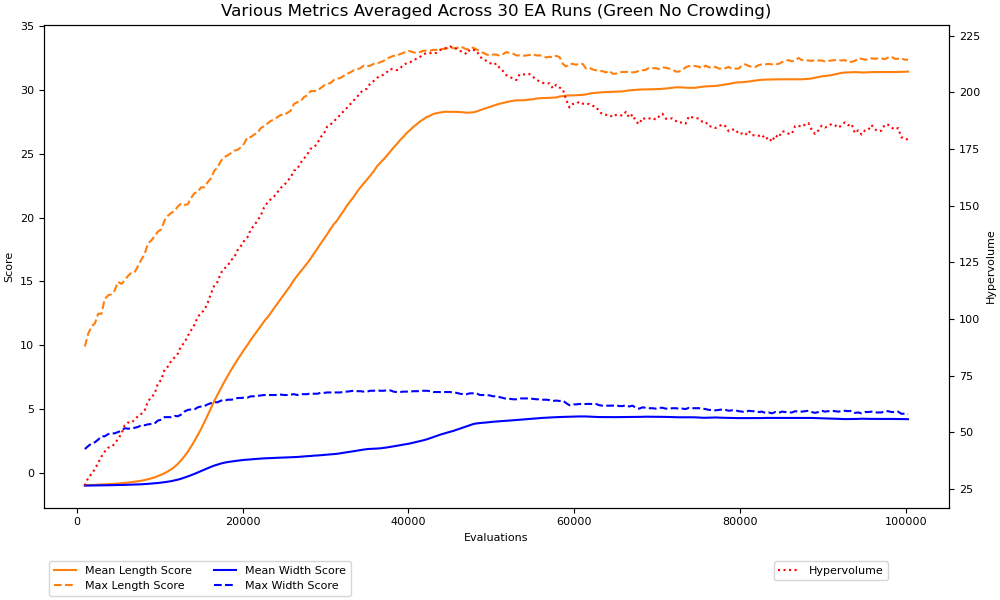

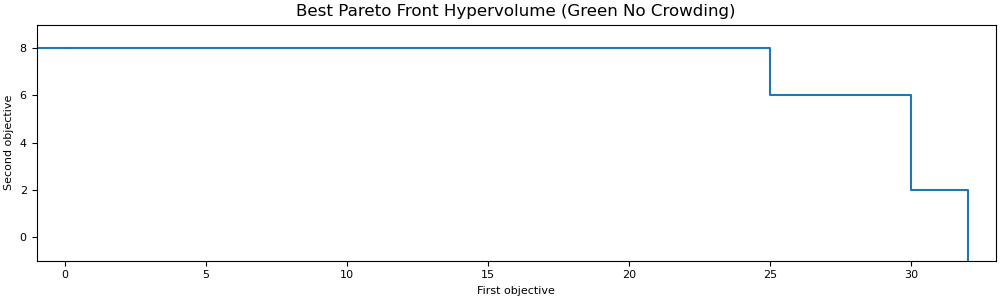

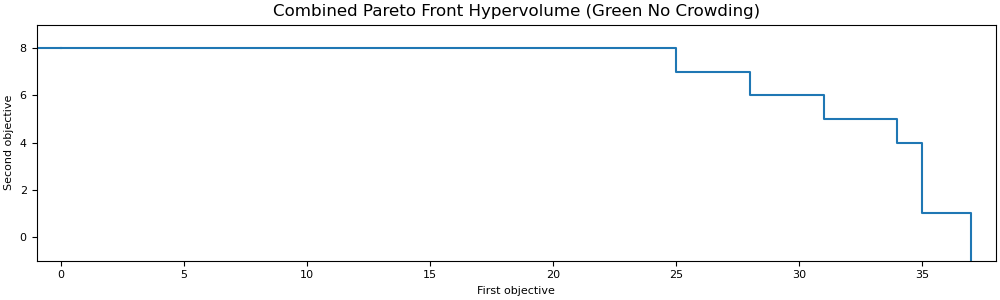

In [91]:
num_runs = 30
num_evaluations = 100_000
green_no_crowding_config = read_config('configs/1d/green_no_crowding_config.txt', globals(), locals())
green_no_crowding_data_path = Path('./data/1d/green_no_crowding/')

experiment_and_save(num_runs,
                    num_evaluations,
                    green_no_crowding_config,
                    green_no_crowding_data_path,
                    'Green No Crowding')

## Report
You should now have all of the experimental data required to complete the report described in the assignment document. There is still one piece missing for the GREEN deliverable, however: statistical analysis.

### Statistical Analysis
Statistical analysis should consist of a comparison between the per-run hypervolumes generated by your two GREEN experiments. Run the following cell to perform this analysis.

In [92]:
# Compare your two GREEN experiments
run_stats('data/1d/green_crowding/hypervolume_per_run.txt', 'data/1d/green_no_crowding/hypervolume_per_run.txt')

Number of samples: 30
data/1d/green_crowding/hypervolume_per_run.txt mean: 213.6
data/1d/green_crowding/hypervolume_per_run.txt stdv: 31.05012632546905
data/1d/green_no_crowding/hypervolume_per_run.txt mean: 178.96666666666667
data/1d/green_no_crowding/hypervolume_per_run.txt stdv: 48.09292967846179
p-value: 0.001724954543288306


# Yellow Deliverable (Bonus for 5660 students, required for 6660 students)
If attempting the 1d yellow deliverable, perform your experiment and analysis below. You may add new cells, if you wish.

Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you delib

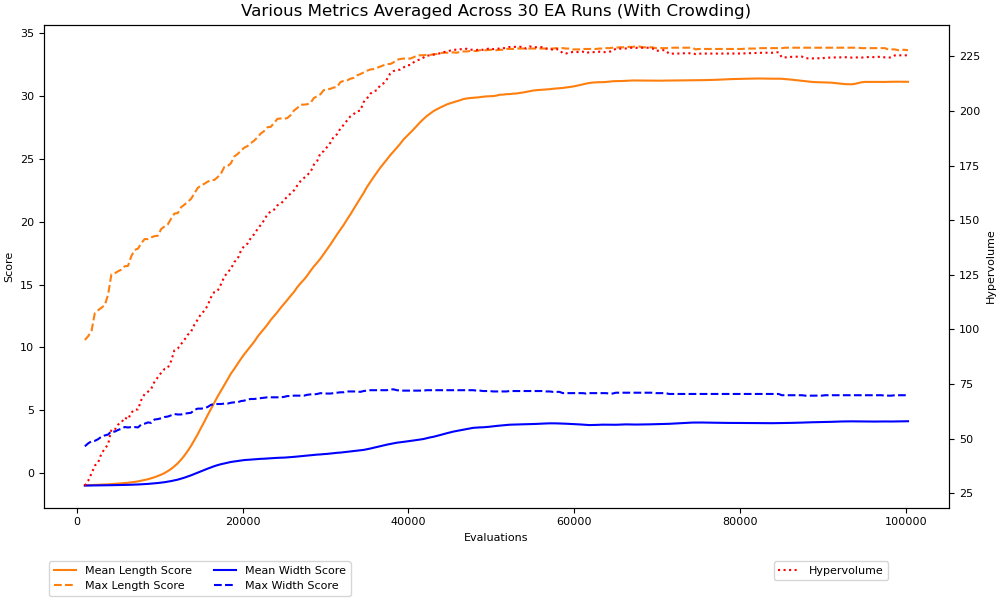

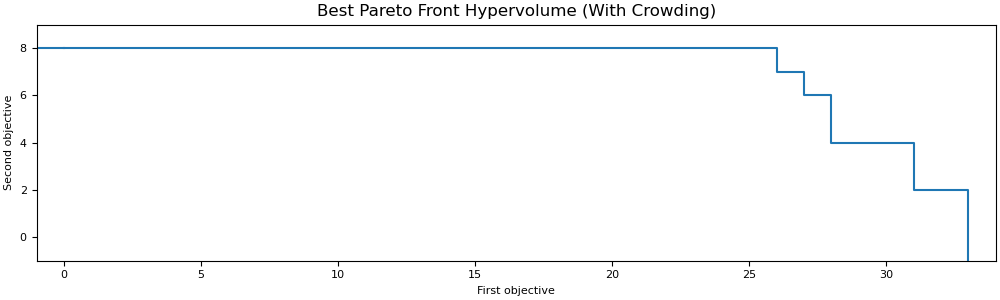

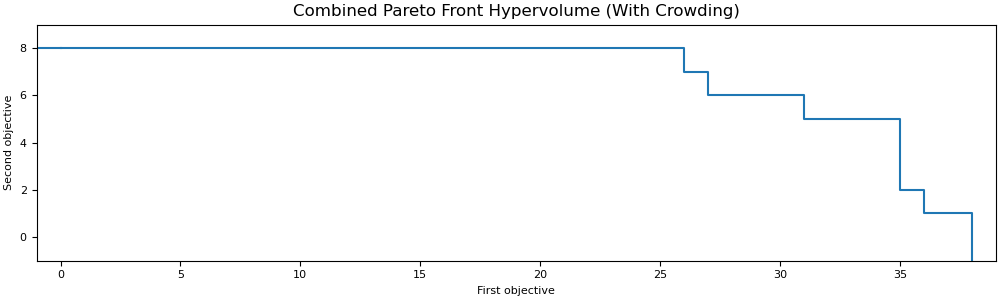

In [31]:
# Experiment with crowding enabled
config_with_crowding = read_config('configs/1d/green_crowding_config.txt', globals(), locals())
config_with_crowding['fitness_kwargs']['crowding'] = True
experiment_and_save(30, 100_000, config_with_crowding, Path('./data/1d/yellow/with_crowding'), 'With Crowding')

Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you delib

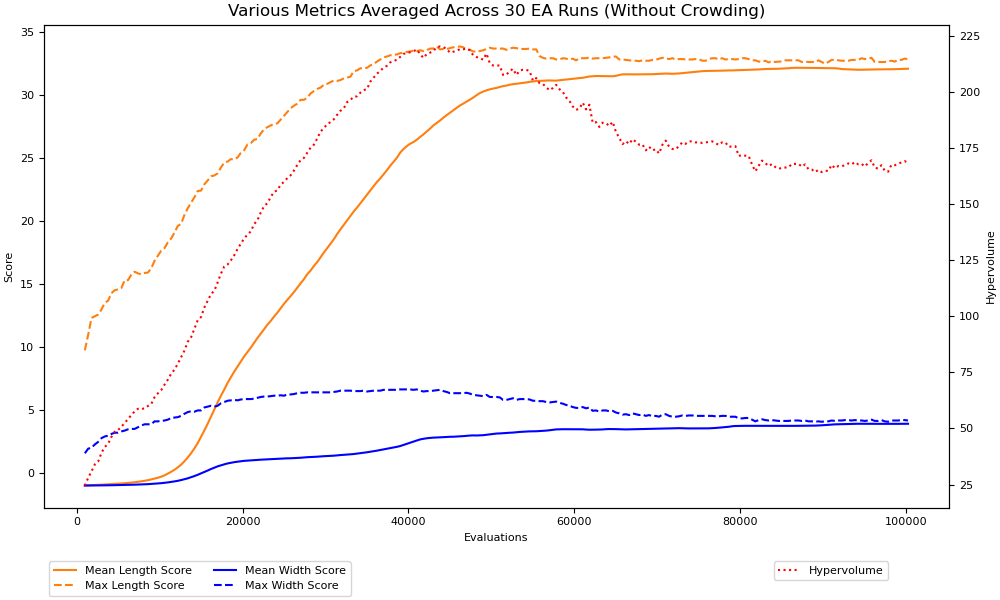

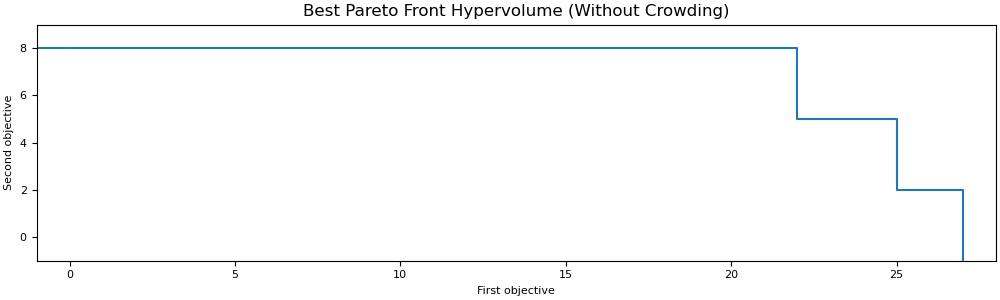

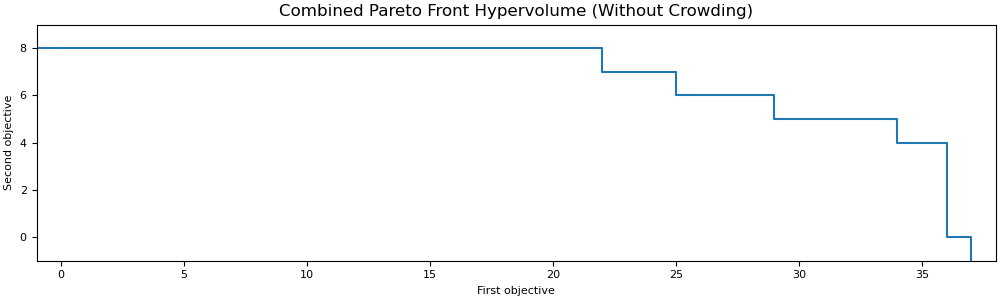

In [32]:
# Experiment with crowding disabled
config_without_crowding = read_config('configs/1d/green_crowding_config.txt', globals(), locals())
config_without_crowding['fitness_kwargs']['crowding'] = False
experiment_and_save(30, 100_000, config_without_crowding, Path('./data/1d/yellow/without_crowding'), 'Without Crowding')

In [44]:
run_stats('data/1d/yellow/with_crowding/hypervolume_per_run.txt', 'data/1d/yellow/without_crowding/hypervolume_per_run.txt')

Number of samples: 30
data/1d/yellow/with_crowding/hypervolume_per_run.txt mean: 225.53333333333333
data/1d/yellow/with_crowding/hypervolume_per_run.txt stdv: 34.48911205836869
data/1d/yellow/without_crowding/hypervolume_per_run.txt mean: 168.4
data/1d/yellow/without_crowding/hypervolume_per_run.txt stdv: 42.0997174206259
p-value: 3.895366856148652e-07


# Red Deliverable (Bonus)
If attempting the 1d red deliverable, perform your experiment and analysis below. You may add new cells, if you wish.

In [74]:
#For RED Deliverable (down below not completed /:)

In [79]:
def extract_pareto_front(population):
    pareto_front = []

    for candidate in population:
        dominated = False
        # Check if candidate is dominated by any other individual in the population
        for other in population:
            if other is candidate:
                continue
            if dominates(other, candidate):
                dominated = True
                break

        if not dominated:
            pareto_front.append(candidate)

    return pareto_front


In [80]:
# random_search_experiment.py

import random

def random_search_run(config, num_evaluations, population_size):
    # Initialize a random population of size `population_size`
    population = LinearGenotype.initialization(population_size, **config['problem'])
    
    # Evaluate the population
    multiobjective_population_evaluation(population, yellow=config.get('yellow', False), **config['problem'])

    # Extract the Pareto front from the population
    pareto_front = extract_pareto_front(population)

    # Calculate the hypervolume dominated by the Pareto front
    hypervolume = calculate_hypervolume(pareto_front)

    return pareto_front, hypervolume


In [81]:
def random_search_experiment(num_runs, num_evaluations, config, population_size):

    hypervolumes_per_run = []
    pareto_fronts = []

    for _ in range(num_runs):
        pareto_front, hypervolume = random_search_run(config, num_evaluations, population_size)
        hypervolumes_per_run.append(hypervolume)
        pareto_fronts.append(pareto_front)

    return pareto_fronts, hypervolumes_per_run


In [82]:
pareto_fronts_random, random_hypervolumes = random_search_experiment(
    num_runs, num_evaluations, config, population_size
)



In [83]:
print("MOEA Hypervolumes:", best_moea_hypervolumes)
print("Random Search Hypervolumes:", random_hypervolumes)



MOEA Hypervolumes: [Ellipsis]
Random Search Hypervolumes: [0, 24, 0, 0, 0, 0, 4, 0, 0, 5, 1, 9, 0, 0, 9, 0, 10, 0, 16, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 12]
